In Kaggle, add the following to the dependencies:
```
pip install torch
pip install numpy
pip install pydicom
pip install PILlow
pip install matplotlib
```
Enable file persistence and internet access.
Remember that you can run the whole notebook and close the runtime without wasting resources by going to File > Save Version > Save & Run All (Double check that GPU is selected in the advanced settings).
Later, by going to 'File' > 'Version history' you can view the full logs and download the output files.

In [1]:
# Check if running in Kaggle
import os

IN_KAGGLE = False
if os.environ.get("KAGGLE_URL_BASE", ""):
    IN_KAGGLE = True
    !git clone https://github.com/parmigggiana/xai /kaggle/working/xai
    %cd xai
    !git fetch
    !git reset --hard origin/main
    %pip install 'monai[einops,itk,nibabel]>=1.5.0' git+https://github.com/timojl/clipseg.git

In [2]:
# Check if running in Google Colab
IN_COLAB = False
if not IN_KAGGLE:
    try:
        import google.colab
        from google.colab import drive

        IN_COLAB = True
        import os

        drive.mount("/content/drive")
        os.makedirs("/content/drive/MyDrive/xai", exist_ok=True)
        !git clone https://github.com/parmigggiana/xai /content/xai
        %cd /content/xai
        !git fetch
        !git reset --hard origin/main
        %pip install -r requirements.txt
    except Exception:
        pass

In [3]:
from src.datasets.registry import get_dataset
from src.datasets.common import BaseDataset
from pathlib import Path
import json
from src.task_vector import TaskVector
from src.utils import download_and_extract_dataset

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
DATASET_NAMES = ["CHAOS", "MMWHS"]
DOMAINS = ["MR", "CT"]
DATA_PATH = "data/"
CHECKPOINT_PATH = "checkpoints/"
OUTPUTS_PATH = "outputs/"
USE_3D = False
TRAINING_EPOCHS = {
    ("CHAOS", "CT"): 5,
    ("CHAOS", "MR"): 5,
    ("MMWHS", "MR"): 5,
    ("MMWHS", "CT"): 5,
    
    
}
BATCH_SIZE = 8
SPATIAL_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

In [5]:
CHECKPOINT_PATH = Path(CHECKPOINT_PATH)
OUTPUTS_PATH = Path(OUTPUTS_PATH)
DATA_PATH = Path(DATA_PATH)
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUTS_PATH.mkdir(parents=True, exist_ok=True)

if USE_3D:
    encoder_type = "swin_unetr"
else:
    encoder_type = "clipseg"

In [6]:
import torch
from monai import transforms
from monai.data import MetaTensor


def update_metrics(name, new_metrics):
    metrics_file = OUTPUTS_PATH / "metrics.json"

    if not metrics_file.exists():
        metrics = {}
    else:
        with open(metrics_file, "r") as f:
            metrics = json.load(f)

    metrics[name] = new_metrics
    with open(metrics_file, "w") as f:
        json.dump(metrics, f, indent=4)


def debug_metadata(data):
    """Debug transform to print metadata information"""
    print(f"🔍 DEBUG - Data type: {type(data)}")
    if hasattr(data, "meta"):
        print(
            f"🔍 DEBUG - Metadata keys: {list(data.meta.keys()) if data.meta else 'No meta'}"
        )
        print(f"🔍 DEBUG - Full metadata: {data.meta}")
    if hasattr(data, "shape"):
        print(f"🔍 DEBUG - Shape: {data.shape}")
    if hasattr(data, "dtype"):
        print(f"🔍 DEBUG - Dtype: {data.dtype}")
    print("🔍 DEBUG - " + "=" * 50)
    return data



class MetadataAwareTransform:
    """Wrapper to make transforms work with 4-element tuples"""

    def __init__(self, transform):
        self.transform = transform

    def __call__(self, data_tuple):
        if isinstance(data_tuple, tuple) and len(data_tuple) == 4:
            image, label, dict_data, metadata = data_tuple
            
            # Apply transform only to the image
            try:
                if isinstance(metadata, dict):
                    wrapped = MetaTensor(image, meta=metadata)
                else:
                    wrapped = image
                    
                transformed_image = self.transform(wrapped)
                
                # Extract clean metadata if it's a MetaTensor
                if isinstance(transformed_image, MetaTensor):
                    clean_metadata = dict(transformed_image.meta) if transformed_image.meta else {}
                    # Keep only simple, serializable values
                    filtered_metadata = {}
                    for k, v in clean_metadata.items():
                        if isinstance(v, (str, int, float, bool)):
                            filtered_metadata[k] = v
                    return transformed_image, label, dict_data, filtered_metadata
                
                return transformed_image, label, dict_data, metadata
                
            except Exception as e:
                print(f"Error in transform {self.transform}: {e}")
                return image, label, dict_data, metadata
                
        elif isinstance(data_tuple, tuple) and len(data_tuple) == 2:
            # Fallback for 2-element tuples
            data, metadata = data_tuple
            try:
                if isinstance(metadata, dict):
                    wrapped = MetaTensor(data, meta=metadata)
                else:
                    wrapped = data
                out = self.transform(wrapped)
                if isinstance(out, MetaTensor):
                    clean_metadata = dict(out.meta) if out.meta else {}
                    return out, clean_metadata
                return out, metadata
            except Exception as e:
                print(f"Error in transform: {e}")
                return data, metadata
        else:
            # Fallback for non-tuple input
            return self.transform(data_tuple)


class MetadataCompose:
    """Custom Compose that handles 4-element tuples properly"""

    def __init__(self, transforms_list):
        self.transforms_list = transforms_list

    def __call__(self, *args, **kwargs):
        """Apply transforms sequentially, handling 4-element tuples"""
        if len(args) == 4 and not kwargs:
            # Handle 4-element tuple: (image, label, dict_data, metadata)
            image, label, dict_data, metadata = args
            data_tuple = (image, label, dict_data, metadata)
        elif len(args) == 2 and not kwargs:
            # Handle 2-element tuple: (data, metadata)
            data, metadata = args
            data_tuple = (data, metadata)
        elif len(args) == 1:
            data_tuple = args[0]
        else:
            raise ValueError(f"Unexpected arguments: args={args}, kwargs={kwargs}")

        if isinstance(data_tuple, tuple) and len(data_tuple) == 4:
            image, label, dict_data, metadata = data_tuple

            # Apply each transform sequentially to the image only
            for transform in self.transforms_list:
                if isinstance(transform, MetadataAwareTransform):
                    image, label, dict_data, metadata = transform((image, label, dict_data, metadata))
                else:
                    # For regular transforms, just transform the image
                    image = transform(image)

            return image, label, dict_data, metadata
            
        elif isinstance(data_tuple, tuple) and len(data_tuple) == 2:
            # Handle 2-element tuples
            data, metadata = data_tuple
            for transform in self.transforms_list:
                if isinstance(transform, MetadataAwareTransform):
                    data, metadata = transform((data, metadata))
                else:
                    data = transform(data)
            return data, metadata
            
        else:
            # Fallback for non-tuple input
            result = data_tuple
            for transform in self.transforms_list:
                if isinstance(transform, MetadataAwareTransform):
                    result = transform.transform(result)
                else:
                    result = transform(result)
            return result

    def set_random_state(self, seed=None):
        """Set random state for randomizable transforms"""
        for transform in self.transforms_list:
            if hasattr(transform, "set_random_state"):
                transform.set_random_state(seed=seed)
            elif hasattr(transform, "transform") and hasattr(
                transform.transform, "set_random_state"
            ):
                transform.transform.set_random_state(seed=seed)

def get_preprocessing(dataset_name: str, domain: str, is_training=True):
    """
    Get comprehensive preprocessing pipeline for volumetric medical data.

    Returns separate transforms for images and segmentations to work with ImageDataset.
    Handles different file formats based on dataset:
    - CHAOS: DICOM images (directories), PNG labels (directories)
    - MMWHS: NIfTI images and labels

    Note: Spatial transforms (Spacing, Resize) are handled separately to ensure
    synchronized dimensions between images and labels.
    """
    # Image-specific transforms (applied to image files)

    decode_func = get_decode_func(dataset_name, domain)

    if USE_3D:
        image_transforms = [
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            transforms.Orientation(axcodes="RAS"),
        ]
    else:
        image_transforms = [
            # transforms.Lambda(lambda x: print(f"Image: {x.shape}") or x),
            transforms.Lambda(lambda x: x.squeeze(-1)),
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            # transforms.Orientation(axcodes="RA"),
        ]

    # Domain-specific intensity normalization for images
    if domain == "CT":
        image_transforms.append(
            transforms.ScaleIntensityRange(
                a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True
            ),
        )
    else:  # MR
        image_transforms.append(
            transforms.NormalizeIntensity(nonzero=True, channel_wise=True),
        )

    # Training-specific augmentations for images only
    if is_training:
        # Image-only augmentations (safe for ImageDataset)
        augmentation_transforms = [
            transforms.RandGaussianNoise(prob=0.2, std=0.05),
            transforms.RandAdjustContrast(prob=0.2, gamma=(0.9, 1.1)),
        ]
        image_transforms.extend(augmentation_transforms)

    if not USE_3D:
        image_transforms.append(transforms.RepeatChannel(repeats=3))

    # Final conversion to tensor for images
    image_transforms.extend(
        [
            transforms.Resize(
                spatial_size=SPATIAL_SIZE,
                size_mode="longest",
                mode="area",
                anti_aliasing=True,
            ),
            transforms.ToTensor(),
            transforms.EnsureType(dtype=torch.float32),
        ]
    )

    # Segmentation-specific transforms (applied to segmentation files)
    if not USE_3D:
        seg_transforms = [
            transforms.Lambda(lambda x: x.squeeze(-1)),
            transforms.EnsureChannelFirst(
                channel_dim="no_channel"
            ),  # Ensure channel-first format
            # transforms.Orientation(axcodes="RA"),
        ]
    else:
        seg_transforms = [
            transforms.Lambda(lambda x: print(f": {x.shape}") or x),
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            transforms.Orientation(axcodes="RAS"),
        ]

    seg_transforms.extend(
        [
            transforms.Lambda(lambda x: decode_func(x)),
            transforms.Resize(
                spatial_size=SPATIAL_SIZE, size_mode="longest", mode="nearest"
            ),
            transforms.ToTensor(),
            transforms.EnsureType(dtype=torch.float32),
        ]
    )

    # Wrap transforms to handle metadata properly
    metadata_aware_image_transforms = [
        MetadataAwareTransform(t) for t in image_transforms
    ]
    metadata_aware_seg_transforms = [MetadataAwareTransform(t) for t in seg_transforms]

    # Create separate transform pipelines that handle metadata
    image_transform = MetadataCompose(metadata_aware_image_transforms)
    seg_transform = MetadataCompose(metadata_aware_seg_transforms)

    return image_transform, seg_transform


def get_decode_func(dataset_name, domain):
    from src.datasets.mmwhs import mmwhs_labels

    decode = None
    if dataset_name == "CHAOS":
        if domain in ["MR", "MRI"]:

            def decode(labels):
                # Convert intensity values to class indices (keep as float32)
                return labels // 63

        elif domain == "CT":

            def decode(labels):
                return torch.where(labels > 0, 1.0, 0.0)

    elif dataset_name == "MMWHS":

        def decode(labels):
            decoded_labels = torch.zeros_like(labels, dtype=torch.float32)
            for i, label_val in enumerate(mmwhs_labels.keys()):
                decoded_labels[labels == label_val] = i
            return decoded_labels

    if decode is None:
        print(
            f"Warning: No decode function defined for {dataset_name} in {domain}. Returning labels unchanged."
        )

        def decode(labels):
            return labels

    return decode

Finetuning on CHAOS dataset in MR domain with 2d images 
Dataset MR total samples: 623
Split sizes - Train: 436, Val: 93, Test: 94

Dataset: CHAOS, Domain: MR
Number of training samples: 436
Number of validation samples: 93
Number of test samples: 94
[DEBUG] index: 0, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00021.dcm, img mean: 105.1600, img shape: torch.Size([256, 256, 1])
Image shape: torch.Size([3, 128, 128])
[DEBUG] index: 0, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00021.dcm, img mean: 105.1600, img shape: torch.Size([256, 256, 1])
Segmentation shape: torch.Size([1, 128, 128])
Number of classes: 5

Found explicit background class in input. Treating it separately.
Non-background classes: ['Liver', 'Right kidney', 'Left kidney', 'Spleen']
🔄 Loading CLIPSeg weights...
🔧 DEBUG: Initial model parameter check
   Total parameters: 356
   Trainable parameters: 54
   Model device: cpu

Processing CHAOS i

Training:   0%|          | 0/55 [00:00<?, ?it/s]

[DEBUG] index: 32, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00010.dcm, img mean: 76.5976, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 3, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00011.dcm, img mean: 141.1445, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 302, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00019.dcm, img mean: 99.1885, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 214, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00003.dcm, img mean: 85.3675, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 158, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00018.dcm, img mean: 109.5609, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 400, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00030.dcm, img mean: 108.2838, img shape: tor

Training:   2%|▏         | 1/55 [00:07<06:51,  7.61s/it, Loss=0.6841]

[DEBUG] index: 418, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00013.dcm, img mean: 132.7695, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 150, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00002.dcm, img mean: 57.2211, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 13, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00021.dcm, img mean: 132.8818, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 79, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00011.dcm, img mean: 104.4752, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 67, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00022.dcm, img mean: 86.7495, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 207, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00028.dcm, img mean: 86.2350, img shape: t

Training:   4%|▎         | 2/55 [00:12<05:12,  5.89s/it, Loss=0.7398]

[DEBUG] index: 191, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00019.dcm, img mean: 97.4696, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 233, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00024.dcm, img mean: 134.0807, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 347, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00017.dcm, img mean: 104.9502, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 269, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00021.dcm, img mean: 88.3863, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 335, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00006.dcm, img mean: 95.7191, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 419, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00011.dcm, img mean: 82.6431, img shape: 

Training:   5%|▌         | 3/55 [00:17<04:45,  5.49s/it, Loss=0.7239]

[DEBUG] index: 319, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00024.dcm, img mean: 75.0213, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 373, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00001.dcm, img mean: 98.8398, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 44, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00028.dcm, img mean: 95.3767, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 320, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00025.dcm, img mean: 113.7592, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 85, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00025.dcm, img mean: 117.7506, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 303, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00006.dcm, img mean: 116.6318, img shape: 

Training:   7%|▋         | 4/55 [00:22<04:32,  5.34s/it, Loss=0.7215]

[DEBUG] index: 355, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00020.dcm, img mean: 98.7588, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 294, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00021.dcm, img mean: 126.1678, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 408, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00011.dcm, img mean: 74.4114, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 36, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00021.dcm, img mean: 61.8680, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 75, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00018.dcm, img mean: 67.3458, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 55, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00006.dcm, img mean: 94.1354, img shape: torch

Training:   9%|▉         | 5/55 [00:27<04:24,  5.30s/it, Loss=0.6744]

[DEBUG] index: 345, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00032.dcm, img mean: 93.0690, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 280, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00011.dcm, img mean: 116.0274, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 78, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00007.dcm, img mean: 114.7002, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 134, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00019.dcm, img mean: 88.5544, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 242, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00009.dcm, img mean: 75.4641, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 68, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00010.dcm, img mean: 105.9393, img shape: 

Training:  11%|█         | 6/55 [00:33<04:23,  5.37s/it, Loss=0.6618]

[DEBUG] index: 98, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00015.dcm, img mean: 116.9487, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 235, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00021.dcm, img mean: 92.4914, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 407, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00028.dcm, img mean: 17.8222, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 379, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00010.dcm, img mean: 104.1050, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 393, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00001.dcm, img mean: 75.4017, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 164, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00027.dcm, img mean: 92.2357, img shape: t

Training:  13%|█▎        | 7/55 [00:37<04:06,  5.14s/it, Loss=0.6516]

[DEBUG] index: 169, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00002.dcm, img mean: 85.8974, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 132, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00013.dcm, img mean: 82.7273, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 321, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00008.dcm, img mean: 98.4945, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 123, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00021.dcm, img mean: 95.5572, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 174, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00017.dcm, img mean: 151.8141, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 259, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00018.dcm, img mean: 109.1939, img shape:

Training:  15%|█▍        | 8/55 [00:42<03:57,  5.06s/it, Loss=0.6395]

[DEBUG] index: 197, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00013.dcm, img mean: 123.0253, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 386, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00027.dcm, img mean: 56.1927, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 33, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00029.dcm, img mean: 45.4631, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 172, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00009.dcm, img mean: 105.8503, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 166, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00017.dcm, img mean: 113.8158, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 248, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00008.dcm, img mean: 63.1430, img shape

Training:  16%|█▋        | 9/55 [00:47<03:45,  4.91s/it, Loss=0.6353]

[DEBUG] index: 114, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00018.dcm, img mean: 80.8569, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 146, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00015.dcm, img mean: 103.4820, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 329, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00021.dcm, img mean: 144.2188, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 63, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00018.dcm, img mean: 96.2078, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 184, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00010.dcm, img mean: 99.7031, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 344, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00031.dcm, img mean: 30.6132, img shape: t

Training:  18%|█▊        | 10/55 [00:52<03:40,  4.91s/it, Loss=0.6321]

[DEBUG] index: 350, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00027.dcm, img mean: 35.6394, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 211, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00019.dcm, img mean: 117.7749, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 423, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00001.dcm, img mean: 84.1897, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 389, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00010.dcm, img mean: 84.8949, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 2, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00003.dcm, img mean: 120.9006, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 256, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00024.dcm, img mean: 101.0928, img shape: 

Training:  20%|██        | 11/55 [00:57<03:34,  4.88s/it, Loss=0.6309]

[DEBUG] index: 258, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00033.dcm, img mean: 69.0916, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 170, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00021.dcm, img mean: 98.7880, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 298, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00029.dcm, img mean: 138.4879, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 331, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00003.dcm, img mean: 76.9752, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 58, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00013.dcm, img mean: 154.7088, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 368, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00015.dcm, img mean: 109.6269, img shape:

Training:  22%|██▏       | 12/55 [01:01<03:27,  4.82s/it, Loss=0.6224]

[DEBUG] index: 189, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00014.dcm, img mean: 116.8795, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 212, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00020.dcm, img mean: 124.2938, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 125, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00028.dcm, img mean: 26.8239, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 199, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00024.dcm, img mean: 110.6218, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 46, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00026.dcm, img mean: 20.5657, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 118, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00003.dcm, img mean: 88.2026, img shape: t

Training:  24%|██▎       | 13/55 [01:07<03:33,  5.09s/it, Loss=0.6160]

[DEBUG] index: 155, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00003.dcm, img mean: 74.3456, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 112, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00023.dcm, img mean: 113.5468, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 264, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00031.dcm, img mean: 86.6494, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 240, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00002.dcm, img mean: 83.6739, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 310, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00026.dcm, img mean: 15.1180, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 401, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00001.dcm, img mean: 96.6397, img shape: 

Training:  25%|██▌       | 14/55 [01:12<03:33,  5.20s/it, Loss=0.6105]

[DEBUG] index: 361, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00009.dcm, img mean: 75.7539, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 120, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00007.dcm, img mean: 91.5176, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 230, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00003.dcm, img mean: 68.9082, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 9, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00026.dcm, img mean: 49.8103, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 45, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00022.dcm, img mean: 117.0432, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 209, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00012.dcm, img mean: 76.6552, img shape: tor

Training:  27%|██▋       | 15/55 [01:18<03:33,  5.35s/it, Loss=0.6013]

[DEBUG] index: 425, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00002.dcm, img mean: 110.0605, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 260, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00014.dcm, img mean: 80.3985, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 268, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00004.dcm, img mean: 69.0386, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 202, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00008.dcm, img mean: 104.6173, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 367, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00030.dcm, img mean: 90.6545, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 10, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00004.dcm, img mean: 77.6488, img shape: t

Training:  29%|██▉       | 16/55 [01:24<03:39,  5.62s/it, Loss=0.5879]

[DEBUG] index: 183, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00004.dcm, img mean: 79.7143, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 133, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00018.dcm, img mean: 98.8866, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 97, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00021.dcm, img mean: 111.5264, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 188, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00001.dcm, img mean: 71.7891, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 305, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00009.dcm, img mean: 64.8086, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 181, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00001.dcm, img mean: 71.5747, img shape: to

Training:  31%|███       | 17/55 [01:29<03:28,  5.48s/it, Loss=0.5954]

[DEBUG] index: 42, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00016.dcm, img mean: 83.9211, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 204, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00024.dcm, img mean: 114.1328, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 238, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00028.dcm, img mean: 94.4129, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 366, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00002.dcm, img mean: 92.6444, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 49, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00025.dcm, img mean: 93.7723, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 17, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00004.dcm, img mean: 72.5190, img shape: to

Training:  33%|███▎      | 18/55 [01:37<03:41,  5.98s/it, Loss=0.5972]

[DEBUG] index: 109, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00013.dcm, img mean: 87.0788, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 397, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00001.dcm, img mean: 118.3857, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 339, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00020.dcm, img mean: 129.7326, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 70, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00006.dcm, img mean: 76.3294, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 165, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00003.dcm, img mean: 90.2724, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 18, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00024.dcm, img mean: 88.5159, img shape: t

Training:  35%|███▍      | 19/55 [01:44<03:55,  6.54s/it, Loss=0.6016]

[DEBUG] index: 293, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00030.dcm, img mean: 20.4061, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 96, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00010.dcm, img mean: 57.1647, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 90, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00015.dcm, img mean: 91.8045, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 206, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00022.dcm, img mean: 93.8372, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 103, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00001.dcm, img mean: 103.9580, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 198, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00018.dcm, img mean: 115.8895, img shape: to

Training:  36%|███▋      | 20/55 [01:51<03:51,  6.62s/it, Loss=0.5910]

[DEBUG] index: 433, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00013.dcm, img mean: 90.0202, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 363, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00032.dcm, img mean: 62.1402, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 73, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00003.dcm, img mean: 79.6621, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 435, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00003.dcm, img mean: 97.9785, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 219, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00012.dcm, img mean: 100.1973, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 404, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00007.dcm, img mean: 80.6630, img shape: t

Training:  38%|███▊      | 21/55 [01:59<04:00,  7.09s/it, Loss=0.5928]

[DEBUG] index: 375, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00014.dcm, img mean: 104.8818, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 82, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00022.dcm, img mean: 127.2180, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 29, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00029.dcm, img mean: 112.6064, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 200, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00034.dcm, img mean: 65.9572, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 388, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00014.dcm, img mean: 151.6841, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 131, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00028.dcm, img mean: 75.3096, img shape:

Training:  40%|████      | 22/55 [02:06<03:50,  6.99s/it, Loss=0.5934]

[DEBUG] index: 100, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00012.dcm, img mean: 100.7459, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 372, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00024.dcm, img mean: 51.6626, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 186, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00025.dcm, img mean: 97.8009, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 34, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00006.dcm, img mean: 76.4076, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 153, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00010.dcm, img mean: 80.3840, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 236, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00023.dcm, img mean: 82.9096, img shape: to

Training:  42%|████▏     | 23/55 [02:13<03:39,  6.86s/it, Loss=0.5844]

[DEBUG] index: 168, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00026.dcm, img mean: 95.1441, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 35, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00004.dcm, img mean: 72.8334, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 243, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00005.dcm, img mean: 87.2017, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 179, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00007.dcm, img mean: 99.9017, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 74, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00004.dcm, img mean: 71.7982, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 282, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00014.dcm, img mean: 111.2954, img shape: to

Training:  44%|████▎     | 24/55 [02:19<03:31,  6.82s/it, Loss=0.5765]

[DEBUG] index: 48, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00007.dcm, img mean: 111.7311, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 323, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00004.dcm, img mean: 107.6213, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 327, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00016.dcm, img mean: 74.4428, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 19, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00024.dcm, img mean: 17.4086, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 247, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00026.dcm, img mean: 44.6698, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 413, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00026.dcm, img mean: 99.6477, img shape: torc

Training:  45%|████▌     | 25/55 [02:27<03:29,  6.99s/it, Loss=0.5687]

[DEBUG] index: 365, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00027.dcm, img mean: 50.8753, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 315, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00004.dcm, img mean: 80.3669, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 218, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00013.dcm, img mean: 107.0672, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 338, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00014.dcm, img mean: 91.5830, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 56, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00011.dcm, img mean: 78.9292, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 28, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00016.dcm, img mean: 157.7661, img shape: t

Training:  47%|████▋     | 26/55 [02:36<03:44,  7.75s/it, Loss=0.5694]

[DEBUG] index: 271, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00028.dcm, img mean: 114.2489, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 145, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00012.dcm, img mean: 114.6310, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 234, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00014.dcm, img mean: 79.1528, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 0, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00021.dcm, img mean: 105.1600, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 110, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00025.dcm, img mean: 132.7253, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 241, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00001.dcm, img mean: 75.9995, img shape: 

Training:  49%|████▉     | 27/55 [02:44<03:32,  7.57s/it, Loss=0.5704]

[DEBUG] index: 301, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00012.dcm, img mean: 148.4489, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 94, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00028.dcm, img mean: 109.7291, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 380, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00023.dcm, img mean: 62.0988, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 47, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00009.dcm, img mean: 135.2079, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 156, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00018.dcm, img mean: 133.6180, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 129, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00005.dcm, img mean: 82.1100, img shape

Training:  51%|█████     | 28/55 [02:53<03:39,  8.13s/it, Loss=0.5797]

[DEBUG] index: 431, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00023.dcm, img mean: 116.1502, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 279, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00013.dcm, img mean: 75.5790, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 411, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00014.dcm, img mean: 93.4847, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 11, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00013.dcm, img mean: 74.4034, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 352, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00023.dcm, img mean: 93.1349, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 257, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00004.dcm, img mean: 56.0267, img shape: to

Training:  53%|█████▎    | 29/55 [02:59<03:14,  7.49s/it, Loss=0.5867]

[DEBUG] index: 141, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00017.dcm, img mean: 93.6493, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 318, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00010.dcm, img mean: 106.2167, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 144, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00015.dcm, img mean: 81.5890, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 7, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00027.dcm, img mean: 100.9664, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 62, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00011.dcm, img mean: 99.8014, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 403, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00019.dcm, img mean: 85.0608, img shape: t

Training:  55%|█████▍    | 30/55 [03:11<03:38,  8.76s/it, Loss=0.5759]

[DEBUG] index: 428, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00007.dcm, img mean: 102.6768, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 416, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00025.dcm, img mean: 92.5651, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 5, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00031.dcm, img mean: 27.5778, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 326, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00022.dcm, img mean: 134.5467, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 40, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00009.dcm, img mean: 71.8822, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 237, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00014.dcm, img mean: 81.4468, img shape: to

Training:  56%|█████▋    | 31/55 [03:18<03:21,  8.41s/it, Loss=0.5665]

[DEBUG] index: 185, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00012.dcm, img mean: 90.3563, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 410, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00010.dcm, img mean: 108.5346, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 69, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00011.dcm, img mean: 69.0309, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 20, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00015.dcm, img mean: 104.4918, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 289, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00004.dcm, img mean: 74.7797, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 76, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00018.dcm, img mean: 91.4830, img shape: tor

Training:  58%|█████▊    | 32/55 [03:25<03:01,  7.91s/it, Loss=0.5532]

[DEBUG] index: 180, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00015.dcm, img mean: 82.5674, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 341, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00008.dcm, img mean: 77.2317, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 175, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00017.dcm, img mean: 170.4907, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 167, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00024.dcm, img mean: 78.8255, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 275, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00016.dcm, img mean: 110.8672, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 300, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00025.dcm, img mean: 108.7578, img shape:

Training:  60%|██████    | 33/55 [03:33<02:52,  7.84s/it, Loss=0.5559]

[DEBUG] index: 135, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00028.dcm, img mean: 45.6235, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 346, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00004.dcm, img mean: 81.2180, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 140, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00028.dcm, img mean: 58.5902, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 226, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00006.dcm, img mean: 141.5969, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 420, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00021.dcm, img mean: 108.0455, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 126, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00001.dcm, img mean: 93.9123, img shape:

Training:  62%|██████▏   | 34/55 [03:39<02:37,  7.48s/it, Loss=0.5494]

[DEBUG] index: 138, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00026.dcm, img mean: 109.4040, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 50, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00015.dcm, img mean: 86.8171, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 106, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00015.dcm, img mean: 91.8336, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 417, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00038.dcm, img mean: 51.0592, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 354, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00012.dcm, img mean: 91.4322, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 87, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00014.dcm, img mean: 109.3248, img shape: to

Training:  64%|██████▎   | 35/55 [03:46<02:26,  7.32s/it, Loss=0.5508]

[DEBUG] index: 115, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00014.dcm, img mean: 69.4267, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 57, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00022.dcm, img mean: 118.0613, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 394, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00012.dcm, img mean: 100.3999, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 187, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00030.dcm, img mean: 79.8497, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 253, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00024.dcm, img mean: 93.6288, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 360, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00020.dcm, img mean: 106.3674, img shape: 

Training:  65%|██████▌   | 36/55 [03:53<02:16,  7.17s/it, Loss=0.5370]

[DEBUG] index: 414, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00022.dcm, img mean: 109.0350, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 1, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00011.dcm, img mean: 103.9715, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 311, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00025.dcm, img mean: 98.4318, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 231, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00028.dcm, img mean: 57.2499, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 244, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00021.dcm, img mean: 108.1788, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 147, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00024.dcm, img mean: 109.4676, img shape: 

Training:  67%|██████▋   | 37/55 [03:59<02:04,  6.90s/it, Loss=0.5295]

[DEBUG] index: 276, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00007.dcm, img mean: 90.9686, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 239, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00018.dcm, img mean: 153.2386, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 157, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00021.dcm, img mean: 86.2456, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 107, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00001.dcm, img mean: 61.8935, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 229, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00035.dcm, img mean: 61.2454, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 295, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00012.dcm, img mean: 78.6937, img shape: 

Training:  69%|██████▉   | 38/55 [04:06<01:55,  6.82s/it, Loss=0.5374]

[DEBUG] index: 162, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00004.dcm, img mean: 96.7873, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 309, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00004.dcm, img mean: 92.5194, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 249, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00022.dcm, img mean: 138.1261, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 399, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00009.dcm, img mean: 98.3416, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 343, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00001.dcm, img mean: 83.2074, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 432, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00008.dcm, img mean: 79.7426, img shape:

Training:  71%|███████   | 39/55 [04:12<01:47,  6.72s/it, Loss=0.5486]

[DEBUG] index: 415, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00024.dcm, img mean: 126.9397, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 312, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00014.dcm, img mean: 73.4234, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 387, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00008.dcm, img mean: 108.0233, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 143, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00017.dcm, img mean: 96.2697, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 52, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00015.dcm, img mean: 109.4512, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 390, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00031.dcm, img mean: 70.1389, img shape

Training:  73%|███████▎  | 40/55 [04:19<01:40,  6.67s/it, Loss=0.5553]

[DEBUG] index: 314, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00025.dcm, img mean: 55.7587, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 291, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00016.dcm, img mean: 117.1620, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 265, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00018.dcm, img mean: 94.8098, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 139, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00025.dcm, img mean: 96.7686, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 223, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00016.dcm, img mean: 108.0214, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 340, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00012.dcm, img mean: 103.3716, img shape:

Training:  75%|███████▍  | 41/55 [04:26<01:34,  6.77s/it, Loss=0.5578]

[DEBUG] index: 51, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00019.dcm, img mean: 151.4353, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 190, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00006.dcm, img mean: 70.7512, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 427, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00035.dcm, img mean: 65.0366, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 89, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00015.dcm, img mean: 130.7068, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 317, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00020.dcm, img mean: 135.5670, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 278, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00002.dcm, img mean: 101.7641, img shape

Training:  76%|███████▋  | 42/55 [04:33<01:29,  6.87s/it, Loss=0.5683]

[DEBUG] index: 285, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00021.dcm, img mean: 132.3420, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 392, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00023.dcm, img mean: 126.9192, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 227, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00032.dcm, img mean: 77.6617, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 405, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00016.dcm, img mean: 83.9113, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 39, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00025.dcm, img mean: 15.4457, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 176, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00018.dcm, img mean: 109.8522, img shape:

Training:  78%|███████▊  | 43/55 [04:40<01:21,  6.81s/it, Loss=0.5728]

[DEBUG] index: 92, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00006.dcm, img mean: 96.9000, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 61, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00022.dcm, img mean: 90.3486, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 30, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00010.dcm, img mean: 84.2417, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 136, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00007.dcm, img mean: 105.1420, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 232, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00005.dcm, img mean: 90.2491, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 72, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00019.dcm, img mean: 120.6656, img shape: torc

Training:  80%|████████  | 44/55 [04:46<01:12,  6.63s/it, Loss=0.5580]

[DEBUG] index: 332, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00003.dcm, img mean: 109.4988, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 31, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00008.dcm, img mean: 90.4346, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 245, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00017.dcm, img mean: 108.6333, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 59, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00020.dcm, img mean: 97.8194, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 116, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00026.dcm, img mean: 93.0405, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 203, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00009.dcm, img mean: 104.4558, img shape: t

Training:  82%|████████▏ | 45/55 [04:52<01:04,  6.45s/it, Loss=0.5468]

[DEBUG] index: 284, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00017.dcm, img mean: 134.1910, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 409, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00016.dcm, img mean: 104.8826, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 217, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00023.dcm, img mean: 67.4953, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 161, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00023.dcm, img mean: 78.4788, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 357, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00006.dcm, img mean: 103.3711, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 322, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00009.dcm, img mean: 96.8679, img shape:

Training:  84%|████████▎ | 46/55 [04:59<00:58,  6.54s/it, Loss=0.5430]

[DEBUG] index: 250, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00001.dcm, img mean: 67.2706, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 159, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00022.dcm, img mean: 108.9048, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 66, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00030.dcm, img mean: 92.0050, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 336, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00016.dcm, img mean: 142.5742, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 24, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00006.dcm, img mean: 98.2576, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 378, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00025.dcm, img mean: 28.3664, img shape: t

Training:  85%|████████▌ | 47/55 [05:05<00:51,  6.45s/it, Loss=0.5334]

[DEBUG] index: 296, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00018.dcm, img mean: 109.7397, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 283, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00019.dcm, img mean: 119.0352, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 270, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00009.dcm, img mean: 85.0813, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 27, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00005.dcm, img mean: 74.2764, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 384, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00026.dcm, img mean: 95.6833, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 177, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00022.dcm, img mean: 82.1766, img shape: t

Training:  87%|████████▋ | 48/55 [05:11<00:44,  6.32s/it, Loss=0.5292]

[DEBUG] index: 261, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00012.dcm, img mean: 69.3971, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 290, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00027.dcm, img mean: 101.8235, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 93, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00003.dcm, img mean: 65.0163, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 422, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00033.dcm, img mean: 89.1615, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 151, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00009.dcm, img mean: 93.2699, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 351, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00012.dcm, img mean: 64.3531, img shape: 

Training:  89%|████████▉ | 49/55 [05:17<00:37,  6.33s/it, Loss=0.5221]

[DEBUG] index: 104, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00023.dcm, img mean: 130.8998, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 288, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00006.dcm, img mean: 77.5604, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 121, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00031.dcm, img mean: 57.0858, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 342, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00026.dcm, img mean: 66.9667, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 273, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00034.dcm, img mean: 89.7539, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 216, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00023.dcm, img mean: 78.0233, img shape: 

Training:  91%|█████████ | 50/55 [05:24<00:31,  6.35s/it, Loss=0.5220]

[DEBUG] index: 272, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00004.dcm, img mean: 80.2470, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 215, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00016.dcm, img mean: 92.9957, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 359, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00019.dcm, img mean: 107.3550, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 213, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00029.dcm, img mean: 113.6385, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 348, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00003.dcm, img mean: 108.2151, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 349, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00027.dcm, img mean: 108.2189, img shape

Training:  93%|█████████▎| 51/55 [05:30<00:25,  6.43s/it, Loss=0.5213]

[DEBUG] index: 307, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00033.dcm, img mean: 66.6079, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 324, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00024.dcm, img mean: 68.2284, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 149, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00031.dcm, img mean: 76.1160, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 154, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00006.dcm, img mean: 93.1157, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 15, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00032.dcm, img mean: 31.5640, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 330, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00011.dcm, img mean: 107.5526, img shape: to

Training:  95%|█████████▍| 52/55 [05:36<00:18,  6.29s/it, Loss=0.5221]

[DEBUG] index: 25, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00029.dcm, img mean: 87.7260, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 333, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00022.dcm, img mean: 102.8208, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 308, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00002.dcm, img mean: 100.6372, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 221, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00020.dcm, img mean: 85.1380, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 182, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00007.dcm, img mean: 103.9807, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 65, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00026.dcm, img mean: 52.0107, img shape: t

Training:  96%|█████████▋| 53/55 [05:42<00:12,  6.23s/it, Loss=0.5244]

[DEBUG] index: 208, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00028.dcm, img mean: 86.5669, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 88, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00010.dcm, img mean: 103.3903, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 374, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00006.dcm, img mean: 99.0399, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 127, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00019.dcm, img mean: 100.0254, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 64, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00013.dcm, img mean: 79.7852, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 369, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00030.dcm, img mean: 27.6358, img shape: 

Training:  98%|█████████▊| 54/55 [05:50<00:06,  6.54s/it, Loss=0.5269]

[DEBUG] index: 60, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00009.dcm, img mean: 90.5274, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 224, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00034.dcm, img mean: 42.5612, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 292, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00012.dcm, img mean: 111.9979, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 376, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00020.dcm, img mean: 94.1188, img shape: torch.Size([320, 320, 1])


Training: 100%|██████████| 55/55 [05:55<00:00,  6.46s/it, Loss=0.5162]


Epoch 1 - Train Loss: 0.5813
   Param norm deltas (after epoch):
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.weight: Δnorm=+0.000000e+00 (before=8.586586e+00, after=8.586586e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.bias: Δnorm=+0.000000e+00 (before=1.183554e+00, after=1.183554e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.1.attn.out_proj.weight: Δnorm=+0.000000e+00 (before=8.633878e+00, after=8.633878e+00)
   Grad non-zero in batches: 55/55 (100.0%)
   Labels seen this epoch: [0, 1, 2, 3, 4]


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

[DEBUG] index: 0, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00005.dcm, img mean: 161.6321, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 1, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00015.dcm, img mean: 71.6246, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 2, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00029.dcm, img mean: 89.8475, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 3, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00021.dcm, img mean: 135.2095, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 4, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00032.dcm, img mean: 49.8598, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 5, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00016.dcm, img mean: 106.7257, img shape: torch.Size

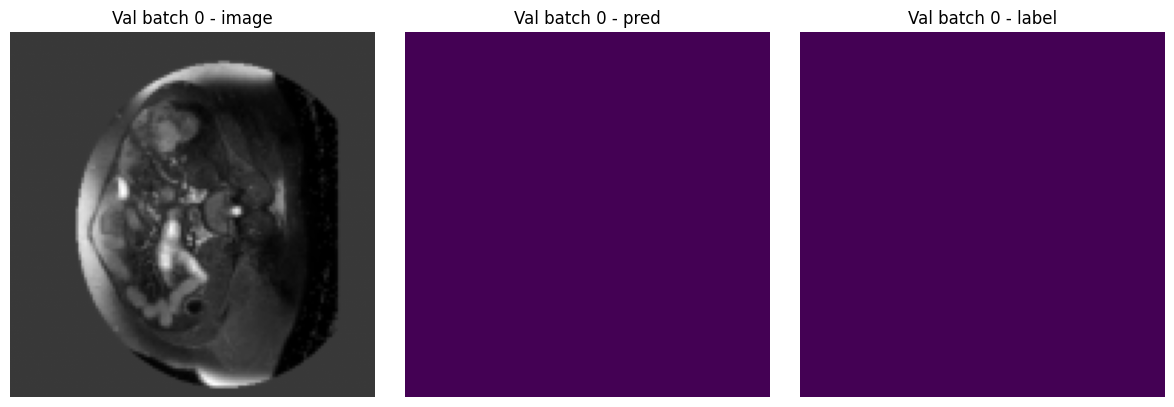

Validating:   8%|▊         | 1/12 [00:07<01:27,  7.98s/it]

[DEBUG] index: 8, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00008.dcm, img mean: 105.8423, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 9, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00003.dcm, img mean: 94.7219, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 10, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00008.dcm, img mean: 112.0756, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 11, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00005.dcm, img mean: 114.4568, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 12, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00017.dcm, img mean: 110.6786, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 13, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00022.dcm, img mean: 62.9708, img shape: torch

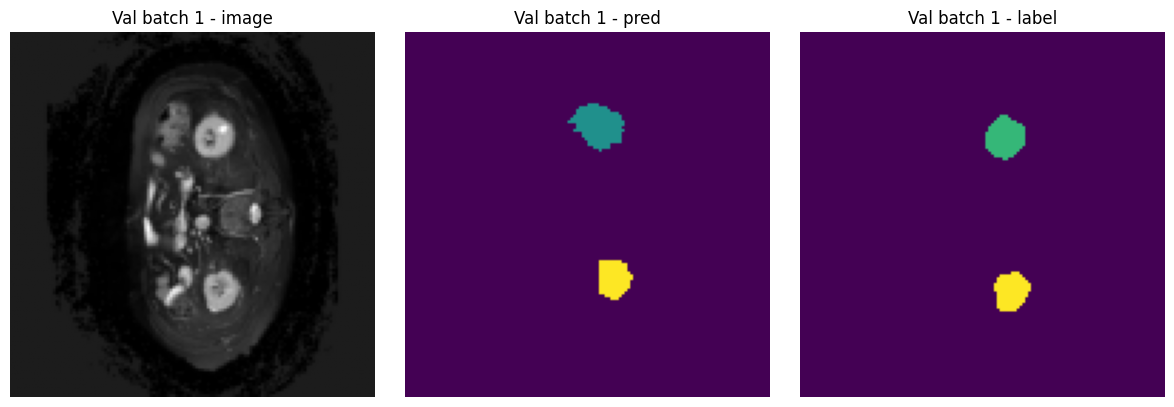

Validating:  17%|█▋        | 2/12 [00:15<01:19,  7.92s/it]

[DEBUG] index: 16, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00030.dcm, img mean: 64.2053, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 17, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00013.dcm, img mean: 78.9438, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 18, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00025.dcm, img mean: 66.8371, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 19, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00019.dcm, img mean: 146.3009, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 20, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00002.dcm, img mean: 73.3670, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 21, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00026.dcm, img mean: 87.2634, img shape: torch

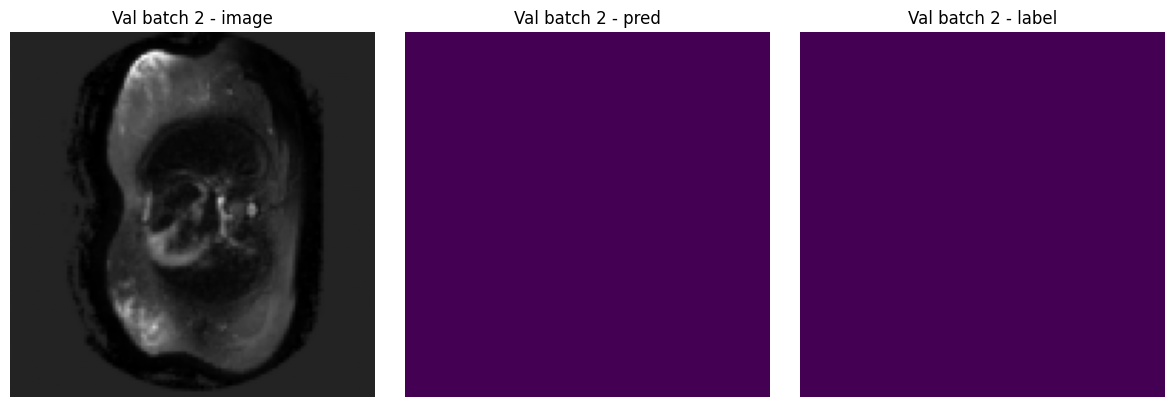

Validating:  25%|██▌       | 3/12 [00:22<01:08,  7.56s/it]

[DEBUG] index: 24, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00008.dcm, img mean: 115.6900, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 25, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00003.dcm, img mean: 58.4146, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 26, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00001.dcm, img mean: 94.4363, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 27, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00032.dcm, img mean: 73.6168, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 28, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00027.dcm, img mean: 104.2980, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 29, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00020.dcm, img mean: 115.4878, img shape: torch.

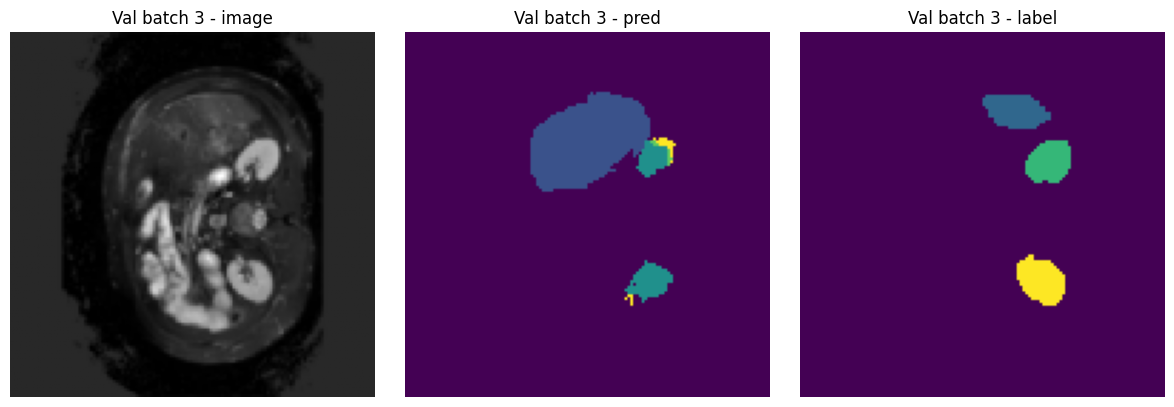

Validating:  33%|███▎      | 4/12 [00:30<01:01,  7.67s/it]

[DEBUG] index: 32, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00008.dcm, img mean: 103.0879, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 33, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00007.dcm, img mean: 96.1382, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 34, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00030.dcm, img mean: 46.1240, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 35, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00008.dcm, img mean: 65.2636, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 36, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00012.dcm, img mean: 120.3259, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 37, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00024.dcm, img mean: 73.0208, img shape: torc

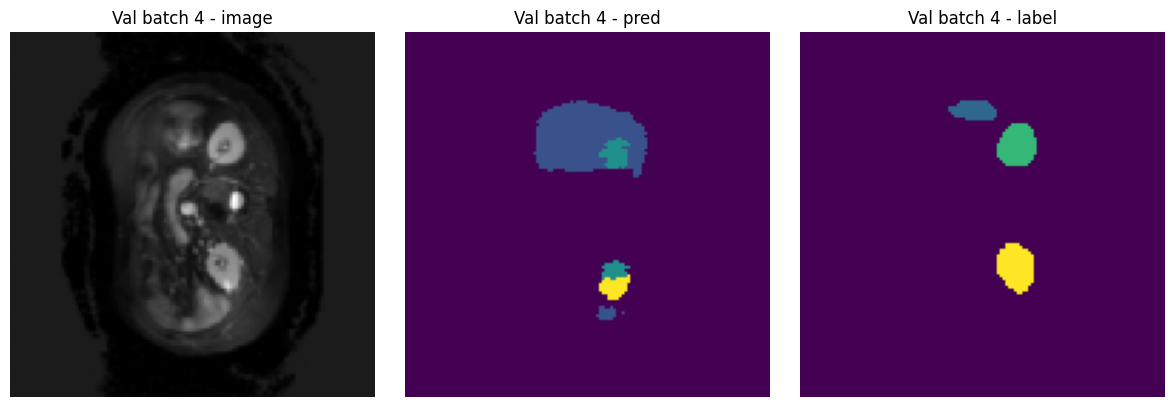

Validating:  42%|████▏     | 5/12 [00:38<00:53,  7.58s/it]

[DEBUG] index: 40, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00017.dcm, img mean: 88.0479, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 41, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00015.dcm, img mean: 149.7529, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 42, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00019.dcm, img mean: 108.1853, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 43, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00037.dcm, img mean: 58.9549, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 44, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00019.dcm, img mean: 108.7925, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 45, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00020.dcm, img mean: 99.5223, img shape: tor

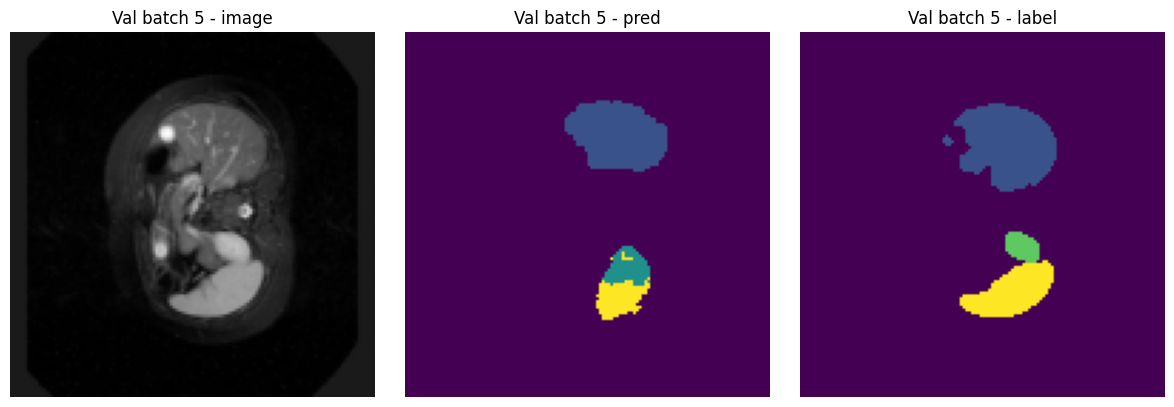

Validating:  50%|█████     | 6/12 [00:44<00:43,  7.24s/it]

[DEBUG] index: 48, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00007.dcm, img mean: 80.2991, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 49, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00036.dcm, img mean: 86.6557, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 50, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00018.dcm, img mean: 161.7618, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 51, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00004.dcm, img mean: 86.2145, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 52, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00020.dcm, img mean: 142.4485, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 53, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00002.dcm, img mean: 86.1830, img shape: torch

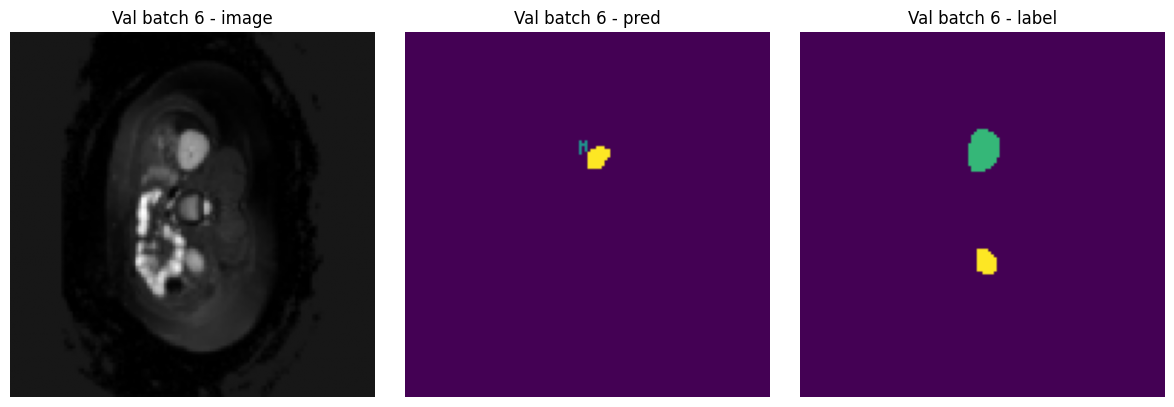

Validating:  58%|█████▊    | 7/12 [00:51<00:35,  7.01s/it]

[DEBUG] index: 56, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00013.dcm, img mean: 98.4695, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 57, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00023.dcm, img mean: 82.3680, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 58, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00020.dcm, img mean: 119.0288, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 59, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00017.dcm, img mean: 116.1679, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 60, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00025.dcm, img mean: 65.6136, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 61, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00022.dcm, img mean: 127.2785, img shape: torc

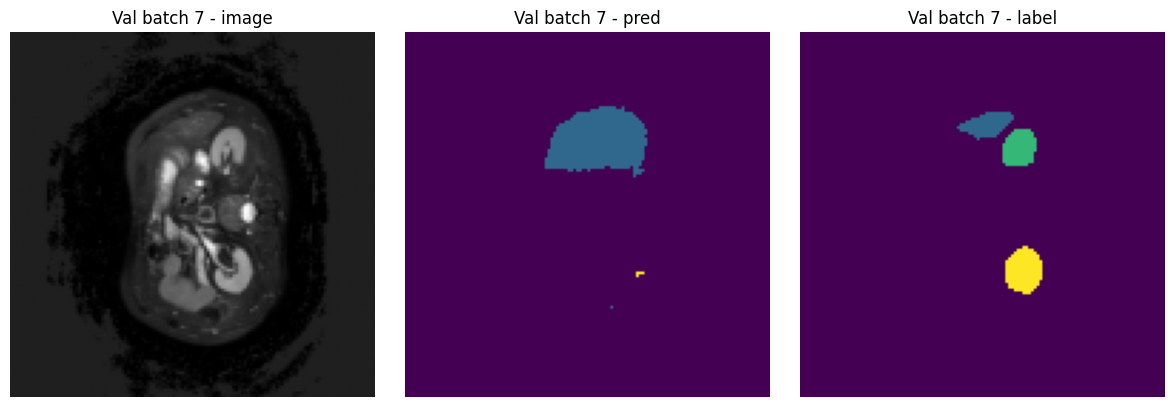

Validating:  67%|██████▋   | 8/12 [00:57<00:26,  6.73s/it]

[DEBUG] index: 64, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00007.dcm, img mean: 90.9642, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 65, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00023.dcm, img mean: 97.2207, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 66, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00017.dcm, img mean: 94.9115, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 67, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00023.dcm, img mean: 98.2866, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 68, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00037.dcm, img mean: 70.9635, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 69, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00004.dcm, img mean: 92.2029, img shape: torch.S

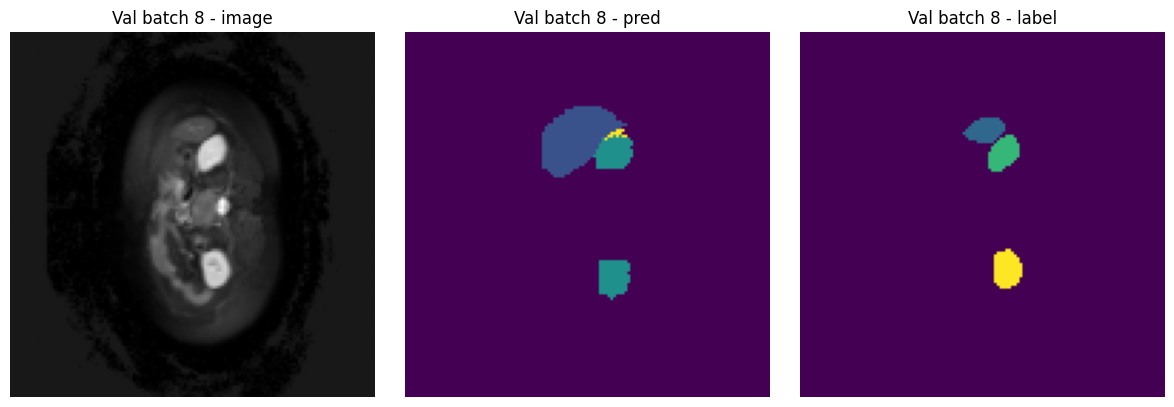

Validating:  75%|███████▌  | 9/12 [01:02<00:18,  6.29s/it]

[DEBUG] index: 72, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00010.dcm, img mean: 140.3533, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 73, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00010.dcm, img mean: 88.3414, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 74, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00029.dcm, img mean: 59.3774, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 75, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00017.dcm, img mean: 108.5268, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 76, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00011.dcm, img mean: 116.8475, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 77, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00019.dcm, img mean: 124.6799, img shape: tor

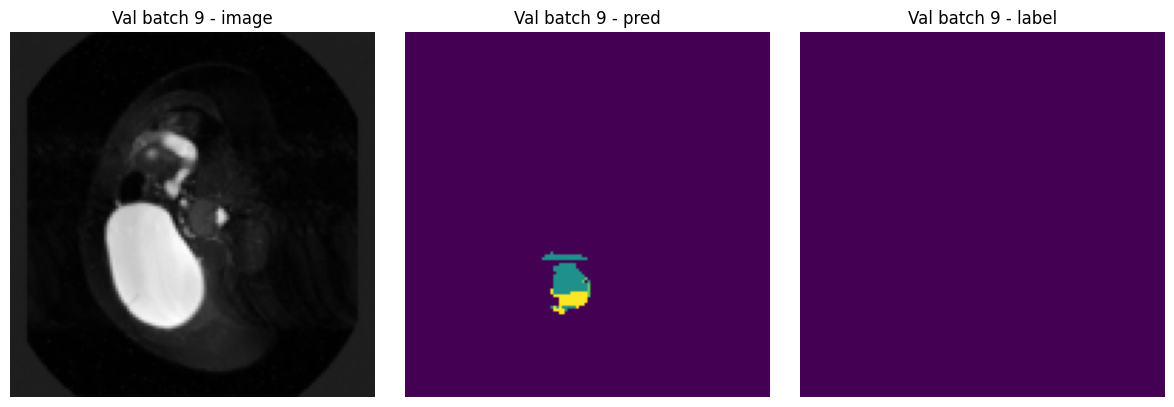

Validating:  83%|████████▎ | 10/12 [01:08<00:12,  6.01s/it]

[DEBUG] index: 80, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00005.dcm, img mean: 99.8351, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 81, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00006.dcm, img mean: 103.8950, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 82, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00029.dcm, img mean: 58.7350, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 83, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00011.dcm, img mean: 101.5122, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 84, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00013.dcm, img mean: 100.8127, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 85, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00022.dcm, img mean: 96.7975, img shape: torch

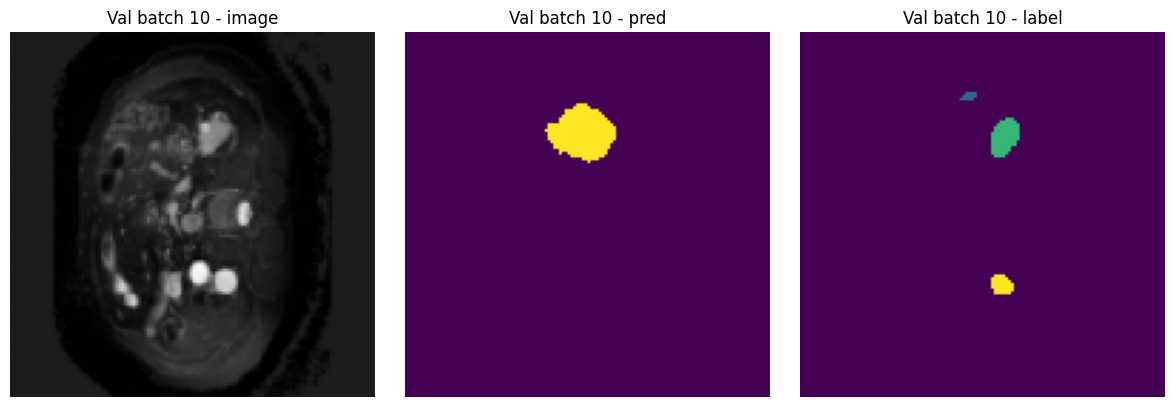

Validating:  92%|█████████▏| 11/12 [01:13<00:05,  5.87s/it]

[DEBUG] index: 88, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00014.dcm, img mean: 84.2232, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 89, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00014.dcm, img mean: 145.3524, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 90, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00023.dcm, img mean: 95.8453, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 91, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00008.dcm, img mean: 81.6885, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 92, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00008.dcm, img mean: 120.3981, img shape: torch.Size([256, 256, 1])


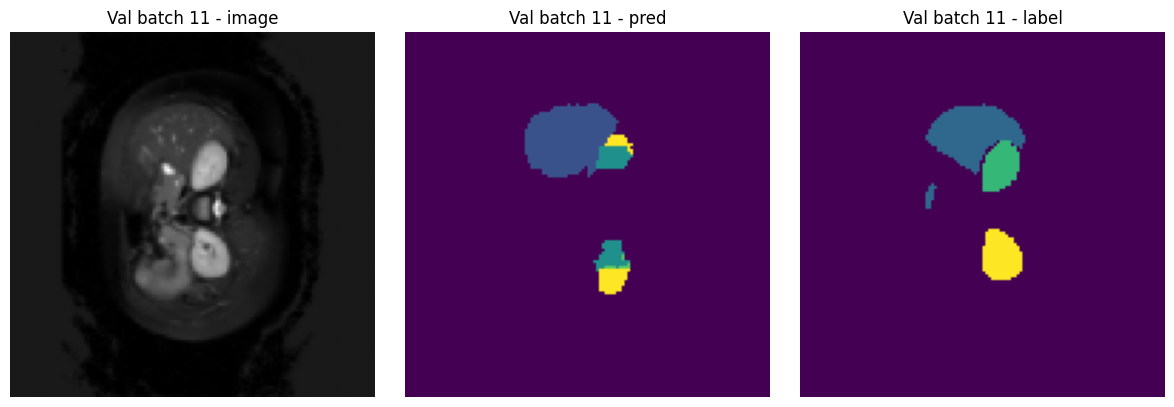

Validating: 100%|██████████| 12/12 [01:18<00:00,  6.54s/it]


Epoch 1 - Val Loss: 0.5218, Val Dice: 0.5816
   ✅ New best Val Dice: 0.5816

📖 Epoch 2/5
   LR(s): 1.000000e-03


Training:   0%|          | 0/55 [00:00<?, ?it/s]

[DEBUG] index: 285, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00021.dcm, img mean: 132.3420, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 186, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00025.dcm, img mean: 97.8009, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 214, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00003.dcm, img mean: 85.3675, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 126, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00001.dcm, img mean: 93.9123, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 73, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00003.dcm, img mean: 79.6621, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 331, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00003.dcm, img mean: 76.9752, img shape: t

Training:   2%|▏         | 1/55 [00:07<06:32,  7.27s/it, Loss=0.5538]

[DEBUG] index: 340, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00012.dcm, img mean: 103.3716, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 205, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00026.dcm, img mean: 56.3113, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 317, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00020.dcm, img mean: 135.5670, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 365, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00027.dcm, img mean: 50.8753, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 371, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00011.dcm, img mean: 109.2221, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 221, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00020.dcm, img mean: 85.1380, img shape:

Training:   4%|▎         | 2/55 [00:13<06:01,  6.82s/it, Loss=0.5540]

[DEBUG] index: 102, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00009.dcm, img mean: 103.0241, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 52, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00015.dcm, img mean: 109.4512, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 99, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00003.dcm, img mean: 70.8760, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 361, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00009.dcm, img mean: 75.7539, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 155, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00003.dcm, img mean: 74.3456, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 58, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00013.dcm, img mean: 154.7088, img shape: t

Training:   5%|▌         | 3/55 [00:20<05:49,  6.71s/it, Loss=0.5526]

[DEBUG] index: 417, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00038.dcm, img mean: 51.0592, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 46, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00026.dcm, img mean: 20.5657, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 48, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00007.dcm, img mean: 111.7311, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 382, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00022.dcm, img mean: 45.2487, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 183, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00004.dcm, img mean: 79.7143, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 51, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00019.dcm, img mean: 151.4353, img shape: tor

Training:   7%|▋         | 4/55 [00:26<05:39,  6.65s/it, Loss=0.5415]

[DEBUG] index: 93, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00003.dcm, img mean: 65.0163, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 287, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00029.dcm, img mean: 82.3786, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 399, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00009.dcm, img mean: 98.3416, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 421, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00002.dcm, img mean: 89.5482, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 57, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00022.dcm, img mean: 118.0613, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 154, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00006.dcm, img mean: 93.1157, img shape: torch

Training:   9%|▉         | 5/55 [00:34<05:58,  7.16s/it, Loss=0.5301]

[DEBUG] index: 38, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00008.dcm, img mean: 119.5541, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 358, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00027.dcm, img mean: 65.8326, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 266, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00006.dcm, img mean: 87.0171, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 370, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00001.dcm, img mean: 74.0830, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 158, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00018.dcm, img mean: 109.5609, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 59, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00020.dcm, img mean: 97.8194, img shape: t

Training:  11%|█         | 6/55 [00:40<05:29,  6.73s/it, Loss=0.5145]

[DEBUG] index: 65, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00026.dcm, img mean: 52.0107, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 265, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00018.dcm, img mean: 94.8098, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 280, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00011.dcm, img mean: 116.0274, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 216, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00023.dcm, img mean: 78.0233, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 241, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00001.dcm, img mean: 75.9995, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 295, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00012.dcm, img mean: 78.6937, img shape: 

Training:  13%|█▎        | 7/55 [00:46<05:01,  6.27s/it, Loss=0.5025]

[DEBUG] index: 410, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00010.dcm, img mean: 108.5346, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 5, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00031.dcm, img mean: 27.5778, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 137, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00005.dcm, img mean: 107.8893, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 239, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00018.dcm, img mean: 153.2386, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 162, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00004.dcm, img mean: 96.7873, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 166, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00017.dcm, img mean: 113.8158, img shape

Training:  15%|█▍        | 8/55 [00:51<04:36,  5.89s/it, Loss=0.5021]

[DEBUG] index: 91, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00012.dcm, img mean: 91.3034, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 7, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00027.dcm, img mean: 100.9664, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 390, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00031.dcm, img mean: 70.1389, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 290, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00027.dcm, img mean: 101.8235, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 76, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00018.dcm, img mean: 91.4830, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 11, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00013.dcm, img mean: 74.4034, img shape: torc

Training:  16%|█▋        | 9/55 [00:56<04:22,  5.70s/it, Loss=0.4996]

[DEBUG] index: 339, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00020.dcm, img mean: 129.7326, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 125, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00028.dcm, img mean: 26.8239, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 378, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00025.dcm, img mean: 28.3664, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 226, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00006.dcm, img mean: 141.5969, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 400, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00030.dcm, img mean: 108.2838, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 202, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00008.dcm, img mean: 104.6173, img sha

Training:  18%|█▊        | 10/55 [01:01<04:12,  5.61s/it, Loss=0.5100]

[DEBUG] index: 256, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00024.dcm, img mean: 101.0928, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 424, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00021.dcm, img mean: 107.6290, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 242, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00009.dcm, img mean: 75.4641, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 324, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00024.dcm, img mean: 68.2284, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 204, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00024.dcm, img mean: 114.1328, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 56, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00011.dcm, img mean: 78.9292, img shape

Training:  20%|██        | 11/55 [01:07<04:02,  5.52s/it, Loss=0.4967]

[DEBUG] index: 333, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00022.dcm, img mean: 102.8208, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 334, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00018.dcm, img mean: 106.9407, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 423, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00001.dcm, img mean: 84.1897, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 1, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00011.dcm, img mean: 103.9715, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 3, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00011.dcm, img mean: 141.1445, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 291, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00016.dcm, img mean: 117.1620, img shape: to

Training:  22%|██▏       | 12/55 [01:12<03:57,  5.53s/it, Loss=0.5100]

[DEBUG] index: 157, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00021.dcm, img mean: 86.2456, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 118, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00003.dcm, img mean: 88.2026, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 391, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00020.dcm, img mean: 67.2194, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 328, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00016.dcm, img mean: 120.0212, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 203, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00009.dcm, img mean: 104.4558, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 30, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00010.dcm, img mean: 84.2417, img shape: 

Training:  24%|██▎       | 13/55 [01:17<03:46,  5.39s/it, Loss=0.5046]

[DEBUG] index: 306, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00023.dcm, img mean: 122.0363, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 271, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00028.dcm, img mean: 114.2489, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 247, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00026.dcm, img mean: 44.6698, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 123, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00021.dcm, img mean: 95.5572, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 357, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00006.dcm, img mean: 103.3711, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 134, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00019.dcm, img mean: 88.5544, img shape

Training:  25%|██▌       | 14/55 [01:23<03:41,  5.41s/it, Loss=0.5153]

[DEBUG] index: 114, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00018.dcm, img mean: 80.8569, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 2, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00003.dcm, img mean: 120.9006, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 15, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00032.dcm, img mean: 31.5640, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 356, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00032.dcm, img mean: 59.3708, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 24, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00006.dcm, img mean: 98.2576, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 20, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00015.dcm, img mean: 104.4918, img shape: torch.

Training:  27%|██▋       | 15/55 [01:28<03:35,  5.39s/it, Loss=0.5134]

[DEBUG] index: 47, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00009.dcm, img mean: 135.2079, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 345, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00032.dcm, img mean: 93.0690, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 36, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00021.dcm, img mean: 61.8680, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 282, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00014.dcm, img mean: 111.2954, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 39, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00025.dcm, img mean: 15.4457, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 219, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00012.dcm, img mean: 100.1973, img shape: to

Training:  29%|██▉       | 16/55 [01:33<03:28,  5.33s/it, Loss=0.5076]

[DEBUG] index: 40, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00009.dcm, img mean: 71.8822, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 435, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00003.dcm, img mean: 97.9785, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 197, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00013.dcm, img mean: 123.0253, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 31, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00008.dcm, img mean: 90.4346, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 148, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00001.dcm, img mean: 101.2690, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 396, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00035.dcm, img mean: 36.1739, img shape: tor

Training:  31%|███       | 17/55 [01:39<03:27,  5.46s/it, Loss=0.5197]

[DEBUG] index: 217, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00023.dcm, img mean: 67.4953, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 96, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00010.dcm, img mean: 57.1647, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 173, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00008.dcm, img mean: 105.1162, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 225, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00014.dcm, img mean: 117.0439, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 351, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00012.dcm, img mean: 64.3531, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 409, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00016.dcm, img mean: 104.8826, img shape: 

Training:  33%|███▎      | 18/55 [01:45<03:30,  5.68s/it, Loss=0.5135]

[DEBUG] index: 381, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00002.dcm, img mean: 102.7687, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 147, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00024.dcm, img mean: 109.4676, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 240, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00002.dcm, img mean: 83.6739, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 97, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00021.dcm, img mean: 111.5264, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 232, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00005.dcm, img mean: 90.2491, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 298, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00029.dcm, img mean: 138.4879, img shape

Training:  35%|███▍      | 19/55 [01:52<03:30,  5.84s/it, Loss=0.5331]

[DEBUG] index: 233, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00024.dcm, img mean: 134.0807, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 6, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00005.dcm, img mean: 91.0791, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 431, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00023.dcm, img mean: 116.1502, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 311, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00025.dcm, img mean: 98.4318, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 414, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00022.dcm, img mean: 109.0350, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 119, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00004.dcm, img mean: 77.5653, img shape: to

Training:  36%|███▋      | 20/55 [01:57<03:22,  5.79s/it, Loss=0.5186]

[DEBUG] index: 244, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00021.dcm, img mean: 108.1788, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 301, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00012.dcm, img mean: 148.4489, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 159, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00022.dcm, img mean: 108.9048, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 407, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00028.dcm, img mean: 17.8222, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 375, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00014.dcm, img mean: 104.8818, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 272, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00004.dcm, img mean: 80.2470, img shap

Training:  38%|███▊      | 21/55 [02:03<03:19,  5.87s/it, Loss=0.5244]

[DEBUG] index: 254, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00007.dcm, img mean: 94.1949, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 64, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00013.dcm, img mean: 79.7852, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 178, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00014.dcm, img mean: 100.7481, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 415, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00024.dcm, img mean: 126.9397, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 432, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00008.dcm, img mean: 79.7426, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 374, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00006.dcm, img mean: 99.0399, img shape: 

Training:  40%|████      | 22/55 [02:09<03:12,  5.85s/it, Loss=0.5148]

[DEBUG] index: 211, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00019.dcm, img mean: 117.7749, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 243, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00005.dcm, img mean: 87.2017, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 308, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00002.dcm, img mean: 100.6372, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 279, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00013.dcm, img mean: 75.5790, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 132, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00013.dcm, img mean: 82.7273, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 372, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00024.dcm, img mean: 51.6626, img shape: t

Training:  42%|████▏     | 23/55 [02:15<03:04,  5.77s/it, Loss=0.5135]

[DEBUG] index: 299, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00019.dcm, img mean: 69.8269, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 419, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00011.dcm, img mean: 82.6431, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 196, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00004.dcm, img mean: 151.3176, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 26, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00006.dcm, img mean: 60.6710, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 315, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00004.dcm, img mean: 80.3669, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 427, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00035.dcm, img mean: 65.0366, img shape: t

Training:  44%|████▎     | 24/55 [02:21<03:00,  5.82s/it, Loss=0.5230]

[DEBUG] index: 335, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00006.dcm, img mean: 95.7191, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 300, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00025.dcm, img mean: 108.7578, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 190, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00006.dcm, img mean: 70.7512, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 140, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00028.dcm, img mean: 58.5902, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 251, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00034.dcm, img mean: 64.7109, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 222, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00001.dcm, img mean: 101.5780, img shape

Training:  45%|████▌     | 25/55 [02:27<03:00,  6.03s/it, Loss=0.5339]

[DEBUG] index: 276, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00007.dcm, img mean: 90.9686, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 21, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00016.dcm, img mean: 135.3804, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 44, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00028.dcm, img mean: 95.3767, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 368, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00015.dcm, img mean: 109.6269, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 215, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00016.dcm, img mean: 92.9957, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 63, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00018.dcm, img mean: 96.2078, img shape: tor

Training:  47%|████▋     | 26/55 [02:33<02:53,  5.99s/it, Loss=0.5293]

[DEBUG] index: 122, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00011.dcm, img mean: 77.0516, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 235, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00021.dcm, img mean: 92.4914, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 364, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00015.dcm, img mean: 107.3245, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 138, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00026.dcm, img mean: 109.4040, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 141, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00017.dcm, img mean: 93.6493, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 218, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00013.dcm, img mean: 107.0672, img shap

Training:  49%|████▉     | 27/55 [02:39<02:47,  5.97s/it, Loss=0.5130]

[DEBUG] index: 86, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00005.dcm, img mean: 85.1288, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 422, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00033.dcm, img mean: 89.1615, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 199, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00024.dcm, img mean: 110.6218, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 90, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00015.dcm, img mean: 91.8045, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 71, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00002.dcm, img mean: 74.5505, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 37, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00024.dcm, img mean: 51.2806, img shape: torc

Training:  51%|█████     | 28/55 [02:45<02:41,  5.97s/it, Loss=0.4952]

[DEBUG] index: 237, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00014.dcm, img mean: 81.4468, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 34, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00006.dcm, img mean: 76.4076, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 347, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00017.dcm, img mean: 104.9502, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 192, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00027.dcm, img mean: 124.4305, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 171, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00006.dcm, img mean: 93.7231, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 49, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00025.dcm, img mean: 93.7723, img shape: t

Training:  53%|█████▎    | 29/55 [02:51<02:36,  6.04s/it, Loss=0.4919]

[DEBUG] index: 394, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00012.dcm, img mean: 100.3999, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 319, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00024.dcm, img mean: 75.0213, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 42, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00016.dcm, img mean: 83.9211, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 230, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00003.dcm, img mean: 68.9082, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 53, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00018.dcm, img mean: 102.7502, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 336, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00016.dcm, img mean: 142.5742, img shape: t

Training:  55%|█████▍    | 30/55 [02:57<02:31,  6.06s/it, Loss=0.4764]

[DEBUG] index: 163, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00025.dcm, img mean: 42.8653, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 117, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00005.dcm, img mean: 97.8654, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 380, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00023.dcm, img mean: 62.0988, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 245, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00017.dcm, img mean: 108.6333, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 212, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00020.dcm, img mean: 124.2938, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 17, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00004.dcm, img mean: 72.5190, img shape: t

Training:  56%|█████▋    | 31/55 [03:03<02:25,  6.07s/it, Loss=0.4792]

[DEBUG] index: 326, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00022.dcm, img mean: 134.5467, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 313, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00003.dcm, img mean: 72.0973, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 344, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00031.dcm, img mean: 30.6132, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 252, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00004.dcm, img mean: 118.3696, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 238, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00028.dcm, img mean: 94.4129, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 135, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00028.dcm, img mean: 45.6235, img shape: t

Training:  58%|█████▊    | 32/55 [03:10<02:22,  6.18s/it, Loss=0.4954]

[DEBUG] index: 129, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00005.dcm, img mean: 82.1100, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 164, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00027.dcm, img mean: 92.2357, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 94, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00028.dcm, img mean: 109.7291, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 277, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00005.dcm, img mean: 76.2661, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 354, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00012.dcm, img mean: 91.4322, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 286, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00010.dcm, img mean: 64.3700, img shape: to

Training:  60%|██████    | 33/55 [03:16<02:14,  6.12s/it, Loss=0.5015]

[DEBUG] index: 284, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00017.dcm, img mean: 134.1910, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 343, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00001.dcm, img mean: 83.2074, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 195, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00027.dcm, img mean: 84.9156, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 201, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00027.dcm, img mean: 96.2245, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 127, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00019.dcm, img mean: 100.0254, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 359, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00019.dcm, img mean: 107.3550, img shape

Training:  62%|██████▏   | 34/55 [03:22<02:06,  6.03s/it, Loss=0.4983]

[DEBUG] index: 188, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00001.dcm, img mean: 71.7891, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 12, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00026.dcm, img mean: 98.7666, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 366, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00002.dcm, img mean: 92.6444, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 121, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00031.dcm, img mean: 57.0858, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 14, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00021.dcm, img mean: 101.2788, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 268, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00004.dcm, img mean: 69.0386, img shape: tor

Training:  64%|██████▎   | 35/55 [03:27<01:59,  5.99s/it, Loss=0.4915]

[DEBUG] index: 89, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00015.dcm, img mean: 130.7068, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 377, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00026.dcm, img mean: 74.1146, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 411, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00014.dcm, img mean: 93.4847, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 184, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00010.dcm, img mean: 99.7031, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 236, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00023.dcm, img mean: 82.9096, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 177, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00022.dcm, img mean: 82.1766, img shape: 

Training:  65%|██████▌   | 36/55 [03:34<01:55,  6.06s/it, Loss=0.5005]

[DEBUG] index: 384, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00026.dcm, img mean: 95.6833, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 55, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00006.dcm, img mean: 94.1354, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 113, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00020.dcm, img mean: 88.8212, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 304, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00020.dcm, img mean: 116.1068, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 296, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00018.dcm, img mean: 109.7397, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 144, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00015.dcm, img mean: 81.5890, img shape: 

Training:  67%|██████▋   | 37/55 [03:40<01:49,  6.09s/it, Loss=0.4888]

[DEBUG] index: 318, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00010.dcm, img mean: 106.2167, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 373, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00001.dcm, img mean: 98.8398, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 402, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00004.dcm, img mean: 84.7106, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 104, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00023.dcm, img mean: 130.8998, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 316, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00009.dcm, img mean: 79.2039, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 397, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00001.dcm, img mean: 118.3857, img shape: t

Training:  69%|██████▉   | 38/55 [03:47<01:47,  6.34s/it, Loss=0.4871]

[DEBUG] index: 338, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00014.dcm, img mean: 91.5830, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 149, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00031.dcm, img mean: 76.1160, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 416, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00025.dcm, img mean: 92.5651, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 257, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00004.dcm, img mean: 56.0267, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 269, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00021.dcm, img mean: 88.3863, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 426, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00015.dcm, img mean: 108.3951, img shape: 

Training:  71%|███████   | 39/55 [03:53<01:41,  6.36s/it, Loss=0.4825]

[DEBUG] index: 395, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00017.dcm, img mean: 99.0225, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 349, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00027.dcm, img mean: 108.2189, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 412, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00025.dcm, img mean: 55.3705, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 50, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00015.dcm, img mean: 86.8171, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 84, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00030.dcm, img mean: 56.2978, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 169, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00002.dcm, img mean: 85.8974, img shape: torc

Training:  73%|███████▎  | 40/55 [04:00<01:35,  6.39s/it, Loss=0.5015]

[DEBUG] index: 350, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00027.dcm, img mean: 35.6394, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 275, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00016.dcm, img mean: 110.8672, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 259, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00018.dcm, img mean: 109.1939, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 83, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00003.dcm, img mean: 73.6031, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 109, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00013.dcm, img mean: 87.0788, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 60, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00009.dcm, img mean: 90.5274, img shape: t

Training:  75%|███████▍  | 41/55 [04:06<01:31,  6.50s/it, Loss=0.4965]

[DEBUG] index: 79, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00011.dcm, img mean: 104.4752, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 292, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00012.dcm, img mean: 111.9979, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 255, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00010.dcm, img mean: 109.6117, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 341, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00008.dcm, img mean: 77.2317, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 77, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00005.dcm, img mean: 62.4036, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 70, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00006.dcm, img mean: 76.3294, img shape: to

Training:  76%|███████▋  | 42/55 [04:13<01:26,  6.64s/it, Loss=0.5002]

[DEBUG] index: 61, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00022.dcm, img mean: 90.3486, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 260, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00014.dcm, img mean: 80.3985, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 182, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00007.dcm, img mean: 103.9807, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 401, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00001.dcm, img mean: 96.6397, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 312, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00014.dcm, img mean: 73.4234, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 43, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00002.dcm, img mean: 70.9220, img shape: to

Training:  78%|███████▊  | 43/55 [04:20<01:18,  6.52s/it, Loss=0.4901]

[DEBUG] index: 146, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00015.dcm, img mean: 103.4820, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 325, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00033.dcm, img mean: 64.0641, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 258, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00033.dcm, img mean: 69.0916, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 72, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00019.dcm, img mean: 120.6656, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 223, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00016.dcm, img mean: 108.0214, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 429, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00005.dcm, img mean: 76.0527, img shape: t

Training:  80%|████████  | 44/55 [04:26<01:10,  6.36s/it, Loss=0.4801]

[DEBUG] index: 18, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00024.dcm, img mean: 88.5159, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 179, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00007.dcm, img mean: 99.9017, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 101, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00007.dcm, img mean: 132.6629, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 261, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00012.dcm, img mean: 69.3971, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 369, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00030.dcm, img mean: 27.6358, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 115, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00014.dcm, img mean: 69.4267, img shape: 

Training:  82%|████████▏ | 45/55 [04:32<01:02,  6.28s/it, Loss=0.4755]

[DEBUG] index: 78, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00007.dcm, img mean: 114.7002, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 168, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00026.dcm, img mean: 95.1441, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 200, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00034.dcm, img mean: 65.9572, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 198, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00018.dcm, img mean: 115.8895, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 273, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00034.dcm, img mean: 89.7539, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 176, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00018.dcm, img mean: 109.8522, img shape

Training:  84%|████████▎ | 46/55 [04:41<01:05,  7.26s/it, Loss=0.4781]

[DEBUG] index: 342, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00026.dcm, img mean: 66.9667, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 430, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00007.dcm, img mean: 64.3295, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 376, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00020.dcm, img mean: 94.1188, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 234, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00014.dcm, img mean: 79.1528, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 110, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00025.dcm, img mean: 132.7253, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 45, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00022.dcm, img mean: 117.0432, img shape: t

Training:  85%|████████▌ | 47/55 [04:51<01:04,  8.06s/it, Loss=0.4786]

[DEBUG] index: 392, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00023.dcm, img mean: 126.9192, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 151, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00009.dcm, img mean: 93.2699, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 327, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00016.dcm, img mean: 74.4428, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 33, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00029.dcm, img mean: 45.4631, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 156, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00018.dcm, img mean: 133.6180, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 111, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00024.dcm, img mean: 109.4095, img shape

Training:  87%|████████▋ | 48/55 [05:01<01:00,  8.68s/it, Loss=0.4759]

[DEBUG] index: 67, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00022.dcm, img mean: 86.7495, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 66, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00030.dcm, img mean: 92.0050, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 220, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00026.dcm, img mean: 109.5723, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 428, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00007.dcm, img mean: 102.6768, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 323, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00004.dcm, img mean: 107.6213, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 322, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00009.dcm, img mean: 96.8679, img shape: 

Training:  89%|████████▉ | 49/55 [05:13<00:56,  9.46s/it, Loss=0.4729]

[DEBUG] index: 249, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00022.dcm, img mean: 138.1261, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 22, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00022.dcm, img mean: 76.9288, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 189, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00014.dcm, img mean: 116.8795, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 100, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00012.dcm, img mean: 100.7459, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 191, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00019.dcm, img mean: 97.4696, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 153, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00010.dcm, img mean: 80.3840, img shape: t

Training:  91%|█████████ | 50/55 [05:24<00:49, 10.00s/it, Loss=0.4787]

[DEBUG] index: 32, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00010.dcm, img mean: 76.5976, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 418, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00013.dcm, img mean: 132.7695, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 74, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00004.dcm, img mean: 71.7982, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 124, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00016.dcm, img mean: 93.2619, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 81, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00015.dcm, img mean: 116.7734, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 253, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00024.dcm, img mean: 93.6288, img shape: to

Training:  93%|█████████▎| 51/55 [05:35<00:41, 10.30s/it, Loss=0.4809]

[DEBUG] index: 143, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00017.dcm, img mean: 96.2697, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 139, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00025.dcm, img mean: 96.7686, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 405, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00016.dcm, img mean: 83.9113, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 23, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00002.dcm, img mean: 90.2233, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 231, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00028.dcm, img mean: 57.2499, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 150, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00002.dcm, img mean: 57.2211, img shape: t

Training:  95%|█████████▍| 52/55 [05:44<00:30, 10.06s/it, Loss=0.4968]

[DEBUG] index: 35, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00004.dcm, img mean: 72.8334, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 388, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00014.dcm, img mean: 151.6841, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 246, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00016.dcm, img mean: 97.6246, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 133, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00018.dcm, img mean: 98.8866, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 175, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00017.dcm, img mean: 170.4907, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 170, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00021.dcm, img mean: 98.7880, img shape:

Training:  96%|█████████▋| 53/55 [05:53<00:19,  9.76s/it, Loss=0.5046]

[DEBUG] index: 152, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00013.dcm, img mean: 105.1483, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 310, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00026.dcm, img mean: 15.1180, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 293, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00030.dcm, img mean: 20.4061, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 136, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00007.dcm, img mean: 105.1420, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 75, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00018.dcm, img mean: 67.3458, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 98, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00015.dcm, img mean: 116.9487, img shape: tor

Training:  98%|█████████▊| 54/55 [06:00<00:08,  8.85s/it, Loss=0.5182]

[DEBUG] index: 321, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00008.dcm, img mean: 98.4945, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 193, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00013.dcm, img mean: 97.8938, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 267, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00024.dcm, img mean: 62.2612, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 4, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00018.dcm, img mean: 92.0654, img shape: torch.Size([256, 256, 1])


Training: 100%|██████████| 55/55 [06:07<00:00,  6.69s/it, Loss=0.4858]


Epoch 2 - Train Loss: 0.5029
   Param norm deltas (after epoch):
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.weight: Δnorm=+0.000000e+00 (before=8.586586e+00, after=8.586586e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.bias: Δnorm=+0.000000e+00 (before=1.183554e+00, after=1.183554e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.1.attn.out_proj.weight: Δnorm=+0.000000e+00 (before=8.633878e+00, after=8.633878e+00)
   Grad non-zero in batches: 55/55 (100.0%)
   Labels seen this epoch: [0, 1, 2, 3, 4]


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

[DEBUG] index: 0, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00005.dcm, img mean: 161.6321, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 1, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00015.dcm, img mean: 71.6246, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 2, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00029.dcm, img mean: 89.8475, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 3, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00021.dcm, img mean: 135.2095, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 4, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00032.dcm, img mean: 49.8598, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 5, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00016.dcm, img mean: 106.7257, img shape: torch.Size

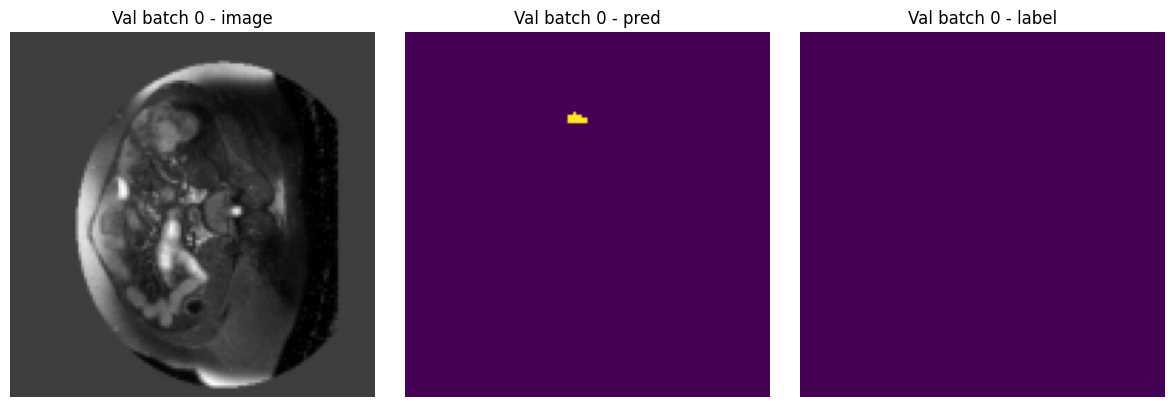

Validating:   8%|▊         | 1/12 [00:08<01:32,  8.38s/it]

[DEBUG] index: 8, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00008.dcm, img mean: 105.8423, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 9, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00003.dcm, img mean: 94.7219, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 10, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00008.dcm, img mean: 112.0756, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 11, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00005.dcm, img mean: 114.4568, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 12, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00017.dcm, img mean: 110.6786, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 13, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00022.dcm, img mean: 62.9708, img shape: torch

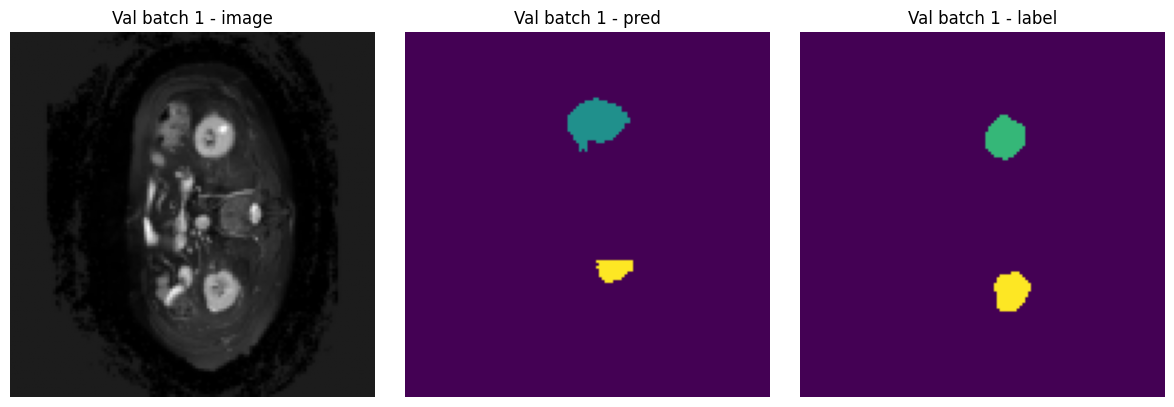

Validating:  17%|█▋        | 2/12 [00:16<01:19,  7.98s/it]

[DEBUG] index: 16, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00030.dcm, img mean: 64.2053, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 17, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00013.dcm, img mean: 78.9438, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 18, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00025.dcm, img mean: 66.8371, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 19, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00019.dcm, img mean: 146.3009, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 20, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00002.dcm, img mean: 73.3670, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 21, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00026.dcm, img mean: 87.2634, img shape: torch

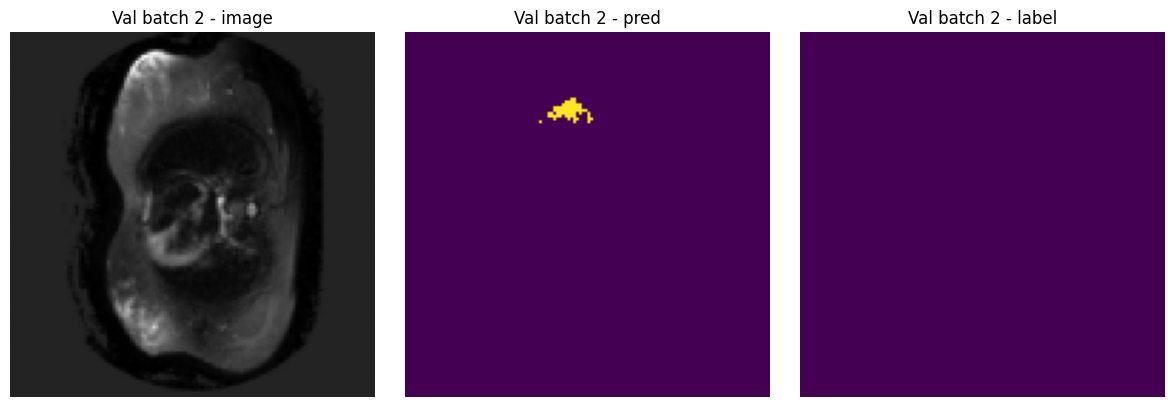

Validating:  25%|██▌       | 3/12 [00:23<01:09,  7.68s/it]

[DEBUG] index: 24, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00008.dcm, img mean: 115.6900, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 25, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00003.dcm, img mean: 58.4146, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 26, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00001.dcm, img mean: 94.4363, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 27, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00032.dcm, img mean: 73.6168, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 28, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00027.dcm, img mean: 104.2980, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 29, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00020.dcm, img mean: 115.4878, img shape: torch.

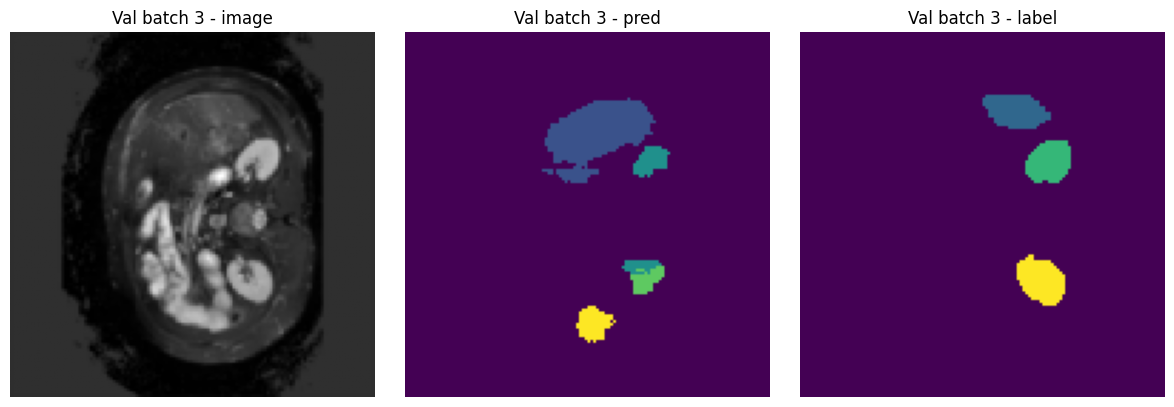

Validating:  33%|███▎      | 4/12 [00:31<01:03,  7.88s/it]

[DEBUG] index: 32, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00008.dcm, img mean: 103.0879, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 33, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00007.dcm, img mean: 96.1382, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 34, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00030.dcm, img mean: 46.1240, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 35, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00008.dcm, img mean: 65.2636, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 36, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00012.dcm, img mean: 120.3259, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 37, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00024.dcm, img mean: 73.0208, img shape: torc

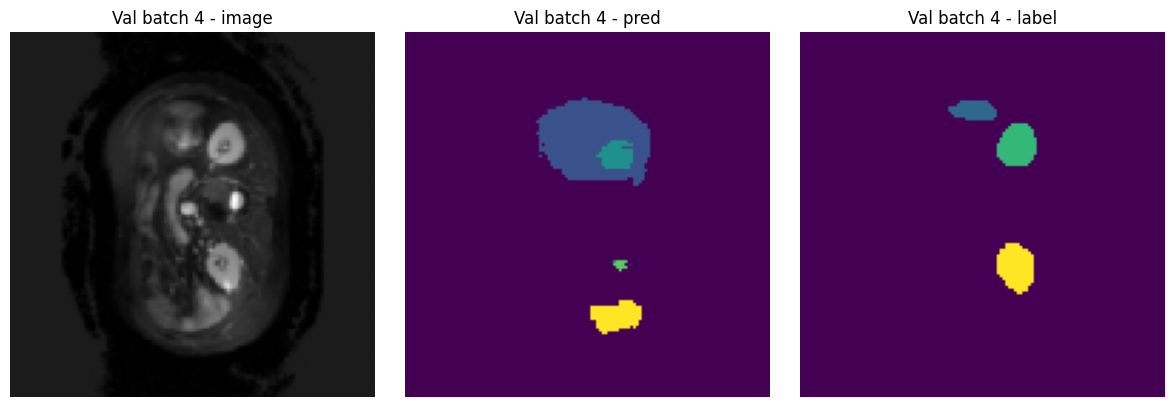

Validating:  42%|████▏     | 5/12 [00:38<00:53,  7.66s/it]

[DEBUG] index: 40, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00017.dcm, img mean: 88.0479, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 41, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00015.dcm, img mean: 149.7529, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 42, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00019.dcm, img mean: 108.1853, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 43, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00037.dcm, img mean: 58.9549, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 44, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00019.dcm, img mean: 108.7925, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 45, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00020.dcm, img mean: 99.5223, img shape: tor

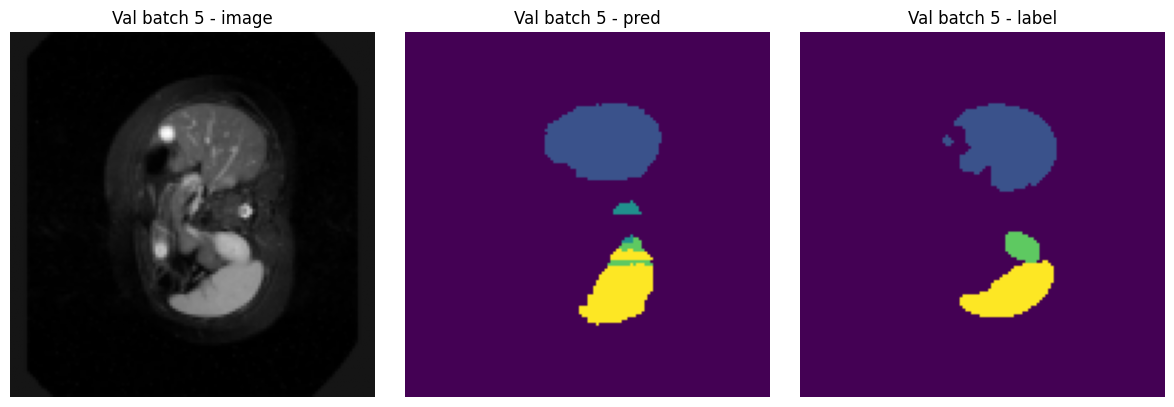

Validating:  50%|█████     | 6/12 [00:48<00:49,  8.21s/it]

[DEBUG] index: 48, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00007.dcm, img mean: 80.2991, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 49, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00036.dcm, img mean: 86.6557, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 50, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00018.dcm, img mean: 161.7618, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 51, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00004.dcm, img mean: 86.2145, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 52, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00020.dcm, img mean: 142.4485, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 53, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00002.dcm, img mean: 86.1830, img shape: torch

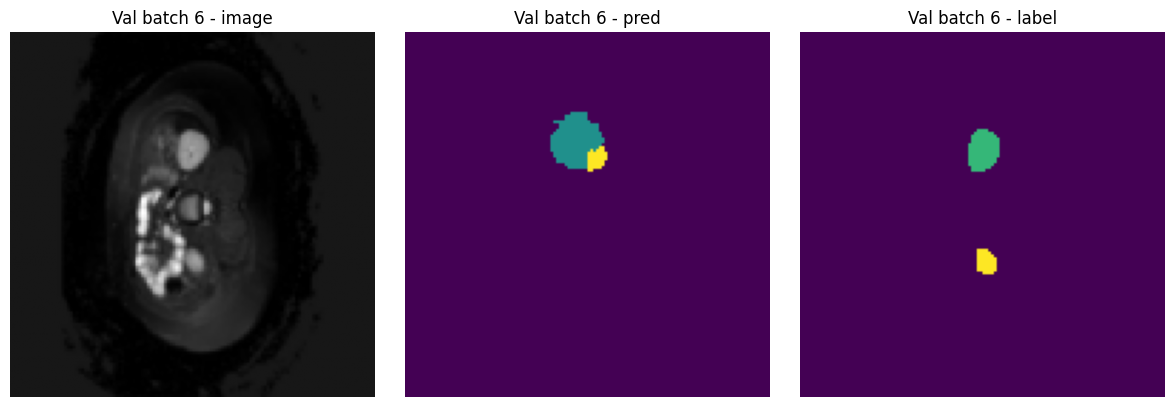

Validating:  58%|█████▊    | 7/12 [00:55<00:39,  7.86s/it]

[DEBUG] index: 56, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00013.dcm, img mean: 98.4695, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 57, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00023.dcm, img mean: 82.3680, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 58, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00020.dcm, img mean: 119.0288, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 59, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00017.dcm, img mean: 116.1679, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 60, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00025.dcm, img mean: 65.6136, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 61, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00022.dcm, img mean: 127.2785, img shape: torc

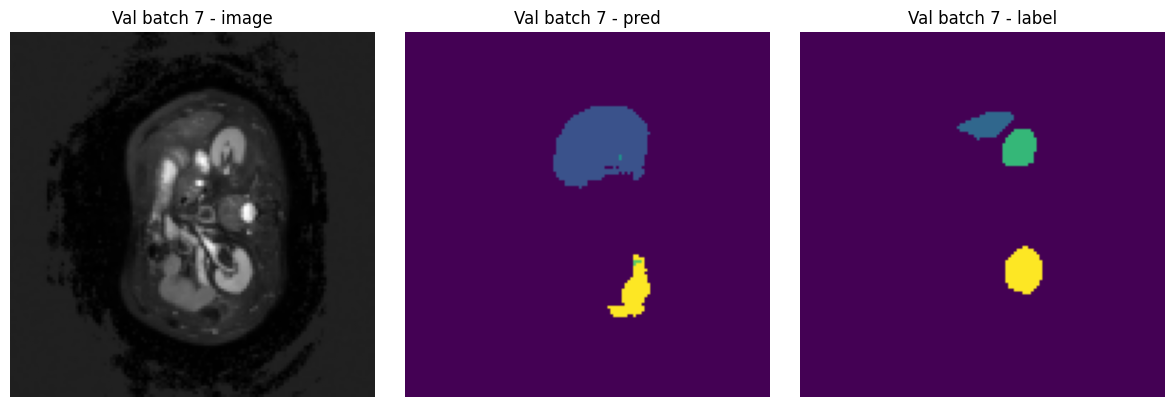

Validating:  67%|██████▋   | 8/12 [01:01<00:29,  7.29s/it]

[DEBUG] index: 64, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00007.dcm, img mean: 90.9642, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 65, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00023.dcm, img mean: 97.2207, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 66, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00017.dcm, img mean: 94.9115, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 67, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00023.dcm, img mean: 98.2866, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 68, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00037.dcm, img mean: 70.9635, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 69, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00004.dcm, img mean: 92.2029, img shape: torch.S

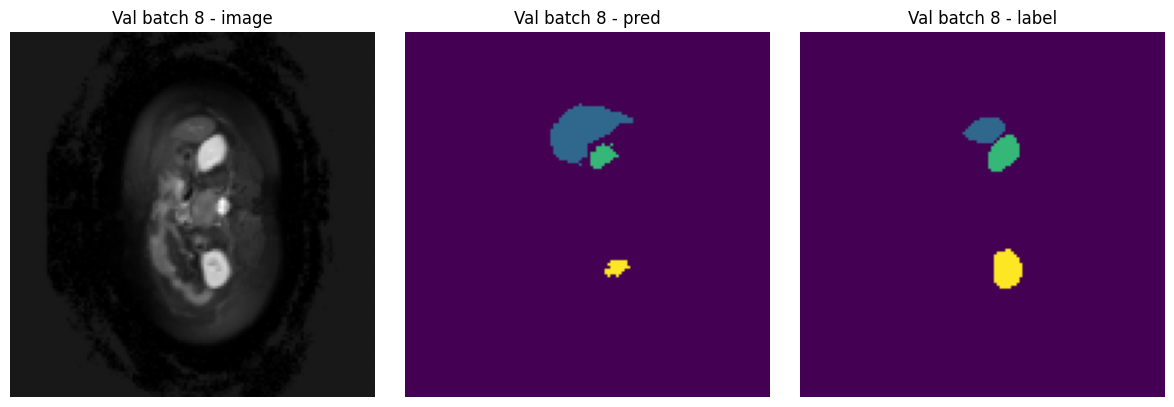

Validating:  75%|███████▌  | 9/12 [01:08<00:21,  7.28s/it]

[DEBUG] index: 72, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00010.dcm, img mean: 140.3533, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 73, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00010.dcm, img mean: 88.3414, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 74, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00029.dcm, img mean: 59.3774, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 75, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00017.dcm, img mean: 108.5268, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 76, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00011.dcm, img mean: 116.8475, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 77, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00019.dcm, img mean: 124.6799, img shape: tor

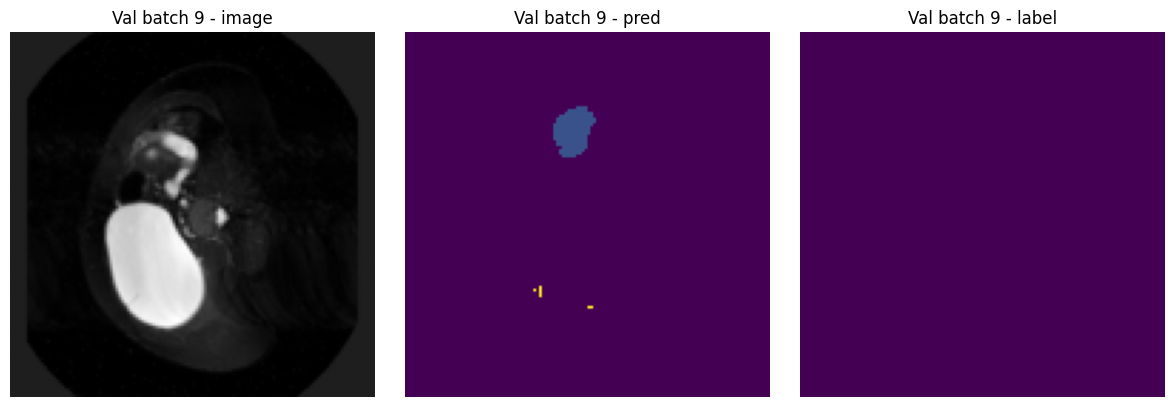

Validating:  83%|████████▎ | 10/12 [01:14<00:13,  6.95s/it]

[DEBUG] index: 80, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00005.dcm, img mean: 99.8351, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 81, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00006.dcm, img mean: 103.8950, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 82, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00029.dcm, img mean: 58.7350, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 83, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00011.dcm, img mean: 101.5122, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 84, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00013.dcm, img mean: 100.8127, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 85, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00022.dcm, img mean: 96.7975, img shape: torch

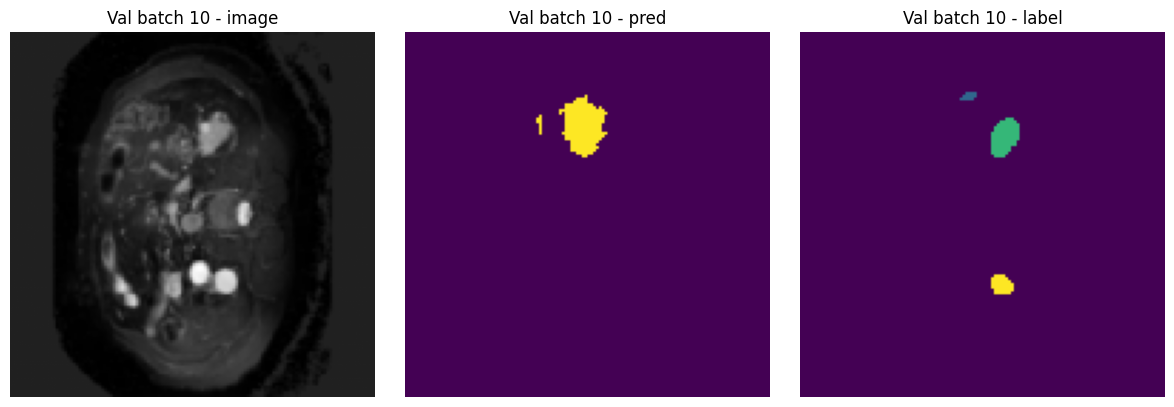

Validating:  92%|█████████▏| 11/12 [01:22<00:07,  7.18s/it]

[DEBUG] index: 88, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00014.dcm, img mean: 84.2232, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 89, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00014.dcm, img mean: 145.3524, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 90, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00023.dcm, img mean: 95.8453, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 91, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00008.dcm, img mean: 81.6885, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 92, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00008.dcm, img mean: 120.3981, img shape: torch.Size([256, 256, 1])


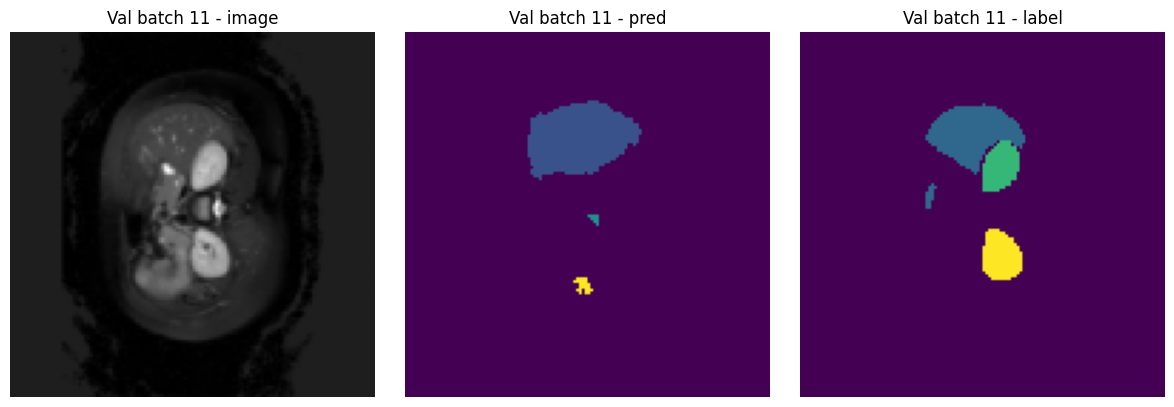

Validating: 100%|██████████| 12/12 [01:28<00:00,  7.37s/it]


Epoch 2 - Val Loss: 0.4918, Val Dice: 0.6663
   ✅ New best Val Dice: 0.6663

📖 Epoch 3/5
   LR(s): 1.000000e-03


Training:   0%|          | 0/55 [00:00<?, ?it/s]

[DEBUG] index: 272, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00004.dcm, img mean: 80.2470, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 340, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00012.dcm, img mean: 103.3716, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 95, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00009.dcm, img mean: 98.2353, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 82, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00022.dcm, img mean: 127.2180, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 179, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\22\T2SPIR\DICOM_anon\IMG-0008-00007.dcm, img mean: 99.9017, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 326, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00022.dcm, img mean: 134.5467, img shape: 

Training:   2%|▏         | 1/55 [00:06<06:13,  6.92s/it, Loss=0.4908]

[DEBUG] index: 246, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00016.dcm, img mean: 97.6246, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 150, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00002.dcm, img mean: 57.2211, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 411, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00014.dcm, img mean: 93.4847, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 375, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00014.dcm, img mean: 104.8818, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 136, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00007.dcm, img mean: 105.1420, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 139, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00025.dcm, img mean: 96.7686, img shape

Training:   4%|▎         | 2/55 [00:14<06:24,  7.26s/it, Loss=0.5015]

[DEBUG] index: 91, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00012.dcm, img mean: 91.3034, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 162, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00004.dcm, img mean: 96.7873, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 235, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00021.dcm, img mean: 92.4914, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 386, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\34\T2SPIR\DICOM_anon\IMG-0008-00027.dcm, img mean: 56.1927, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 234, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00014.dcm, img mean: 79.1528, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 97, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00021.dcm, img mean: 111.5264, img shape: tor

Training:   5%|▌         | 3/55 [00:23<07:00,  8.08s/it, Loss=0.4971]

[DEBUG] index: 29, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00029.dcm, img mean: 112.6064, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 355, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00020.dcm, img mean: 98.7588, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 416, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00025.dcm, img mean: 92.5651, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 126, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00001.dcm, img mean: 93.9123, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 178, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00014.dcm, img mean: 100.7481, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 412, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00025.dcm, img mean: 55.3705, img shape: 

Training:   7%|▋         | 4/55 [00:30<06:32,  7.69s/it, Loss=0.4711]

[DEBUG] index: 184, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00010.dcm, img mean: 99.7031, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 402, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00004.dcm, img mean: 84.7106, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 372, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\2\T2SPIR\DICOM_anon\IMG-0007-00024.dcm, img mean: 51.6626, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 343, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00001.dcm, img mean: 83.2074, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 14, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00021.dcm, img mean: 101.2788, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 230, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00003.dcm, img mean: 68.9082, img shape: to

Training:   9%|▉         | 5/55 [00:39<06:42,  8.05s/it, Loss=0.4680]

[DEBUG] index: 4, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00018.dcm, img mean: 92.0654, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 305, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00009.dcm, img mean: 64.8086, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 266, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00006.dcm, img mean: 87.0171, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 20, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00015.dcm, img mean: 104.4918, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 371, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00011.dcm, img mean: 109.2221, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 149, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00031.dcm, img mean: 76.1160, img shape: tor

Training:  11%|█         | 6/55 [00:47<06:40,  8.18s/it, Loss=0.4671]

[DEBUG] index: 156, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00018.dcm, img mean: 133.6180, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 391, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00020.dcm, img mean: 67.2194, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 33, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\13\T2SPIR\DICOM_anon\IMG-0061-00029.dcm, img mean: 45.4631, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 2, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\32\T2SPIR\DICOM_anon\IMG-0030-00003.dcm, img mean: 120.9006, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 370, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\21\T2SPIR\DICOM_anon\IMG-0001-00001.dcm, img mean: 74.0830, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 148, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\33\T2SPIR\DICOM_anon\IMG-0034-00001.dcm, img mean: 101.2690, img shape: 

Training:  13%|█▎        | 7/55 [00:56<06:46,  8.47s/it, Loss=0.4997]

[DEBUG] index: 291, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\3\T2SPIR\DICOM_anon\IMG-0002-00016.dcm, img mean: 117.1620, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 47, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\36\T2SPIR\DICOM_anon\IMG-0016-00009.dcm, img mean: 135.2079, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 292, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00012.dcm, img mean: 111.9979, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 147, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\37\T2SPIR\DICOM_anon\IMG-0020-00024.dcm, img mean: 109.4676, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 267, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\15\T2SPIR\DICOM_anon\IMG-0073-00024.dcm, img mean: 62.2612, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 397, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\39\T2SPIR\DICOM_anon\IMG-0026-00001.dcm, img mean: 118.3857, img shape

Training:  15%|█▍        | 8/55 [01:04<06:23,  8.15s/it, Loss=0.4995]

[DEBUG] index: 42, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00016.dcm, img mean: 83.9211, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 88, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\20\T2SPIR\DICOM_anon\IMG-0029-00010.dcm, img mean: 103.3903, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 40, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00009.dcm, img mean: 71.8822, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 224, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\1\T2SPIR\DICOM_anon\IMG-0002-00034.dcm, img mean: 42.5612, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 27, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\19\T2SPIR\DICOM_anon\IMG-0024-00005.dcm, img mean: 74.2764, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 9, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00026.dcm, img mean: 49.8103, img shape: torch.S

Training:  16%|█▋        | 9/55 [01:15<06:57,  9.08s/it, Loss=0.5026]

[DEBUG] index: 53, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00018.dcm, img mean: 102.7502, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 31, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\5\T2SPIR\DICOM_anon\IMG-0014-00008.dcm, img mean: 90.4346, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 327, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\38\T2SPIR\DICOM_anon\IMG-0022-00016.dcm, img mean: 74.4428, img shape: torch.Size([320, 320, 1])
[DEBUG] index: 223, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\8\T2SPIR\DICOM_anon\IMG-0031-00016.dcm, img mean: 108.0214, img shape: torch.Size([288, 288, 1])
[DEBUG] index: 365, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\31\T2SPIR\DICOM_anon\IMG-0026-00027.dcm, img mean: 50.8753, img shape: torch.Size([256, 256, 1])
[DEBUG] index: 256, image_file: data\CHAOS\CHAOS_Train_Sets\Train_Sets\MR\10\T2SPIR\DICOM_anon\IMG-0043-00024.dcm, img mean: 101.0928, img shape: to

Training:  16%|█▋        | 9/55 [01:22<06:59,  9.12s/it, Loss=0.5026]


KeyboardInterrupt: 

In [7]:
# Finetuning loop

for (dataset_name, domain), epochs in TRAINING_EPOCHS.items():
    download_and_extract_dataset(dataset_name, DATA_PATH)

    image_transform, seg_transform = get_preprocessing(
        dataset_name, domain, is_training=True
    )

    filename = f"{dataset_name}_{domain}_{'3d' if USE_3D else '2d'}_finetuned.pth"
    filename = CHECKPOINT_PATH / filename
    # Check if the finetuned checkpoint already exists
    if filename.exists():
        print(
            f"Finetuned model for {dataset_name} in {domain} domain with {'3d' if USE_3D else '2d'} images already exists at {filename}. Skipping finetuning."
        )
        continue

    print(
        f"Finetuning on {dataset_name} dataset in {domain} domain with {'3d' if USE_3D else '2d'} images "
    )
    dataset: BaseDataset = get_dataset(
        dataset_name=dataset_name,
        domain=domain,
        transform=image_transform,  # Use transform instead of preprocess
        seg_transform=seg_transform,  # Pass seg_transform too
        base_path=DATA_PATH,
        batch_size=BATCH_SIZE,
        num_workers=0,
        slice_2d=not USE_3D,
    )
    

    #  Ensure the dataset is loaded correctly
    if not isinstance(dataset, BaseDataset):
        raise TypeError(
            f"Expected dataset to be an instance of BaseDataset, got {type(dataset)}"
        )
    # Print dataset information
    print()
    print(f"Dataset: {dataset_name}, Domain: {domain}")
    print(f"Number of training samples: {len(dataset.train_dataset)}")
    print(f"Number of validation samples: {len(dataset.val_dataset)}")
    print(f"Number of test samples: {len(dataset.test_dataset)}")
    print(f"Image shape: {dataset.train_dataset[0][0].shape}")
    print(f"Segmentation shape: {dataset.train_dataset[0][1].shape}")
    print(f"Number of classes: {dataset.num_classes}")
    print()

    model = dataset.get_model(
        encoder_type=encoder_type,
    )

    # 🔧 DEBUG: Check initial model parameters
    print("🔧 DEBUG: Initial model parameter check")
    initial_params = {}
    param_count = 0
    trainable_count = 0
    for name, param in model.named_parameters():
        initial_params[name] = param.clone().detach()
        param_count += 1
        if param.requires_grad:
            trainable_count += 1
    print(f"   Total parameters: {param_count}")
    print(f"   Trainable parameters: {trainable_count}")
    print(f"   Model device: {next(model.parameters()).device}")
    print()

    # Save the baseline model's state_dict before finetuning
    baseline_filename = (
        CHECKPOINT_PATH
        / f"{dataset_name}_{domain}_{'3d' if USE_3D else '2d'}_baseline.pth"
    )
    torch.save(model.encoder, baseline_filename)
    print(
        f"Processing {dataset_name} in {domain} domain with {'3d' if USE_3D else '2d'} images"
    )

    if USE_3D:
        print(
            f"Warning: Using 3D model requires SWIN UNETR, which is not compatible with zero-shot training."
        )
        
        # 🔧 DEBUG: Check freeze_body functionality
        print("🔧 DEBUG: Before freeze_body()")
        frozen_before = sum(1 for p in model.parameters() if not p.requires_grad)
        model.freeze_body()
        frozen_after = sum(1 for p in model.parameters() if not p.requires_grad)
        print(f"   Frozen parameters before: {frozen_before}")
        print(f"   Frozen parameters after: {frozen_after}")
        print(f"   Parameters frozen: {frozen_after - frozen_before}")
        
        # Check which parameters are trainable
        print("   Trainable parameters after freeze_body:")
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(f"     {name}: {param.shape}")
        print()
        
        model.finetune(
            epochs=epochs, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

        metrics = model.evaluate()
        update_metrics(
            f"{dataset_name}_{domain}_{'3d' if USE_3D else '2d'}_head",
            metrics,
        )

    # 🔧 DEBUG: Check unfreeze functionality
    print("🔧 DEBUG: Before unfreeze()")
    frozen_before = sum(1 for p in model.parameters() if not p.requires_grad)
    model.unfreeze()
    frozen_after = sum(1 for p in model.parameters() if not p.requires_grad)
    print(f"   Frozen parameters before unfreeze: {frozen_before}")
    print(f"   Frozen parameters after unfreeze: {frozen_after}")
    print(f"   Total trainable parameters: {sum(1 for p in model.parameters() if p.requires_grad)}")
    print()

    # 🔧 DEBUG: Monitor parameter changes during training
    print("🔧 DEBUG: Starting full model finetuning")
    history = model.finetune(
        epochs=epochs,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
    )
    
    # 🔧 DEBUG: Check if parameters actually changed
    print("🔧 DEBUG: Parameter change analysis after finetuning")
    changed_params = 0
    unchanged_params = 0
    max_change = 0.0
    for name, param in model.named_parameters():
        if name in initial_params:
            param_change = (param - initial_params[name]).norm().item()
            if param_change > 1e-8:  # Consider very small changes as unchanged
                changed_params += 1
                max_change = max(max_change, param_change)
            else:
                unchanged_params += 1
                print(f"   Parameter {name} didn't change during training!")
    
    print(f"   Parameters that changed: {changed_params}")
    print(f"   Parameters that didn't change: {unchanged_params}")
    print(f"   Maximum parameter change: {max_change:.6f}")
    
    if changed_params == 0:
        print("   ⚠️ WARNING: No parameters changed during training!")
    elif max_change < 1e-6:
        print(f"   ⚠️ WARNING: Very small parameter changes (max: {max_change:.8f})")
    else:
        print("   ✅ Parameters updated successfully")
    print()

    # 🔧 DEBUG: Check training history
    if history:
        print("🔧 DEBUG: Training history analysis")
        if 'train_loss' in history:
            train_losses = history['train_loss']
            print(f"   Training losses: {train_losses[:5]}...{train_losses[-5:] if len(train_losses) > 5 else train_losses}")
            print(f"   Loss range: {min(train_losses):.6f} - {max(train_losses):.6f}")
            if len(train_losses) > 1:
                loss_change = abs(train_losses[-1] - train_losses[0])
                print(f"   Total loss change: {loss_change:.6f}")
                if loss_change < 1e-6:
                    print("   ⚠️ WARNING: Training loss barely changed!")
        else:
            print("   ⚠️ No 'train_loss' found in history")
        print(f"   History keys: {list(history.keys()) if history else 'None'}")
    else:
        print("🔧 DEBUG: No training history returned")
    print()

    # Save the finetuned model's state_dict
    torch.save(model.encoder, filename)
    model_metrics = model.evaluate()
    update_metrics(
        f"{dataset_name}_{domain}_{'3d' if USE_3D else '2d'}_finetuned",
        model_metrics,
    )
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# Domain adaptation

In [ ]:
# SWIN UNETR Task Vectors
from monai.networks.nets import SwinUNETR
from monai.networks.nets.swin_unetr import SwinTransformer
from monai.networks.blocks.patchembedding import PatchEmbed
from torch.nn.modules.conv import Conv3d
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.container import ModuleList
from monai.networks.nets.swin_unetr import BasicLayer
from monai.networks.nets.swin_unetr import SwinTransformerBlock
from torch.nn.modules.normalization import LayerNorm
from monai.networks.nets.swin_unetr import WindowAttention
from torch.nn.modules.linear import Linear
from torch.nn.modules.activation import Softmax
from torch.nn.modules.linear import Identity
from monai.networks.blocks.mlp import MLPBlock
from torch.nn.modules.activation import GELU
from monai.networks.nets.swin_unetr import PatchMerging
from monai.networks.blocks.unetr_block import UnetrBasicBlock
from monai.networks.blocks.dynunet_block import UnetResBlock
from monai.networks.blocks.convolutions import Convolution
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.instancenorm import InstanceNorm3d
from monai.networks.blocks.unetr_block import UnetrUpBlock
from monai.networks.blocks.dynunet_block import UnetOutBlock
from torch.nn.modules.conv import ConvTranspose3d

safe_globals = [
    SwinUNETR,
    SwinTransformer,
    PatchEmbed,
    Conv3d,
    Dropout,
    ModuleList,
    BasicLayer,
    SwinTransformerBlock,
    LayerNorm,
    WindowAttention,
    Linear,
    Softmax,
    Identity,
    MLPBlock,
    GELU,
    PatchMerging,
    UnetrBasicBlock,
    UnetResBlock,
    Convolution,
    LeakyReLU,
    InstanceNorm3d,
    UnetrUpBlock,
    ConvTranspose3d,
    UnetOutBlock,
]
##

## CLIPSeg Task Vectors
from src.CLIPSeg import CLIPSeg
from clipseg.clipseg import CLIPDensePredT
from clip.model import (
    CLIP,
    VisionTransformer,
    LayerNorm,
    Transformer,
    ResidualAttentionBlock,
    QuickGELU,
)
from torch.nn.modules.conv import Conv2d, ConvTranspose2d
from torch.nn.modules.container import Sequential
from torch.nn.modules.activation import MultiheadAttention, ReLU
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.modules.sparse import Embedding
from torch.nn.modules.transformer import (
    TransformerEncoderLayer,
    TransformerEncoder,
    TransformerDecoderLayer,
    TransformerDecoder,
)
from torch.nn.functional import relu
from torch.nn.modules.container import ModuleDict

safe_globals.extend(
    [
        CLIPSeg,
        CLIPDensePredT,
        CLIP,
        VisionTransformer,
        Conv2d,
        LayerNorm,
        Transformer,
        Sequential,
        ResidualAttentionBlock,
        MultiheadAttention,
        NonDynamicallyQuantizableLinear,
        QuickGELU,
        Embedding,
        ReLU,
        ConvTranspose2d,
        TransformerEncoderLayer,
        TransformerEncoder,
        TransformerDecoderLayer,
        TransformerDecoder,
        relu,
        ModuleDict,
    ]
)

# Build Task Vectors for each dataset and domain
task_vectors = {}
for dataset_name in DATASET_NAMES:
    for domain in DOMAINS:
        print(
            f"Building task vector for {dataset_name} dataset in {domain} domain with {'3d' if USE_3D else '2d'} images"
        )
        baseline_checkpoint = (
            CHECKPOINT_PATH
            / f"{dataset_name}_{domain}_{'3d' if USE_3D else '2d'}_baseline.pth"
        )
        finetuned_checkpoint = (
            CHECKPOINT_PATH
            / f"{dataset_name}_{domain}_{'3d' if USE_3D else '2d'}_finetuned.pth"
        )
        if not baseline_checkpoint.exists():
            print(
                f"Baseline checkpoint for {dataset_name} {domain} does not exist. Skipping task vector creation."
            )
            continue
        if not finetuned_checkpoint.exists():
            print(
                f"Finetuned checkpoint {dataset_name} {domain} does not exist. Skipping task vector creation."
            )
            continue

        with torch.serialization.safe_globals(
            safe_globals=safe_globals,
        ):
            task_vector = TaskVector(baseline_checkpoint, finetuned_checkpoint)
            # Remove keys associated with the output layers from the task vector
            # For swin it's all layers starting with '.out'
            # For clipseg it might not be necessary since the model architecture isn't dependent on the number of output features
            if encoder_type == "swin_unetr":
                for k in task_vector.keys():
                    if k.startswith(".out"):
                        del task_vector[k]
        task_vectors[f"{dataset_name}_{domain}"] = task_vector

In [ ]:
# Build composite task vectors using arithmetic
composite_task_vectors = {
    "MMWHS_CT": task_vectors["MMWHS_MR"]
    + task_vectors["CHAOS_CT"]
    - task_vectors["CHAOS_MR"],
    "MMWHS_MR": task_vectors["MMWHS_CT"]
    + task_vectors["CHAOS_MR"]
    - task_vectors["CHAOS_CT"],
    "CHAOS_CT": task_vectors["CHAOS_MR"]
    + task_vectors["MMWHS_CT"]
    - task_vectors["MMWHS_MR"],
    "CHAOS_MR": task_vectors["CHAOS_CT"]
    + task_vectors["MMWHS_MR"]
    - task_vectors["MMWHS_CT"],
}

In [ ]:
# 🔄 Task Vector Cross-Domain Adaptation Experiments
print("🔄 Task Vector Cross-Domain Adaptation Experiments")
print("=" * 80)

for dataset_name in DATASET_NAMES:
    for target_domain in DOMAINS:
        print(f"\n{dataset_name}: {target_domain} adaptation")

        image_transform, seg_transform = get_preprocessing(
            dataset_name, domain, is_training=False
        )

        dataset_kwargs = {
            "dataset_name": dataset_name,
            "base_path": DATA_PATH,
            "domain": target_domain,
            "transform": image_transform,  # Use transform instead of preprocess
            "seg_transform": seg_transform,  # Pass seg_transform too
            "batch_size": BATCH_SIZE,
            "num_workers": 0,
            "slide_2d": not USE_3D,
        }
        extra_kwargs = {}
        if dataset_name == "CHAOS":
            extra_kwargs["liver_only"] = True

        # try:
        target_dataset = get_dataset(**dataset_kwargs, **extra_kwargs)

        composite_key = f"{dataset_name}_{target_domain}"
        if composite_key in composite_task_vectors:
            composite_task_vector = composite_task_vectors[composite_key]

            target_model = target_dataset.get_model(encoder_type=encoder_type)
            target_model.load_task_vector(composite_task_vector)

            metrics = target_model.evaluate()
            update_metrics(f"{composite_key}_adaptation", metrics)
            print(
                f"   ✅ {composite_key}: Dice={metrics.get('train', {}).get('dice', 0):.3f}"
            )
        else:
            print(f"   ⚠️ No composite task vector found for {composite_key}")

        # except Exception as e:
        #     print(f"   ❌ {dataset_name} {target_domain}: {str(e)[:100]}...")
        #     import traceback
        #     traceback.print_exc()
        #     # continue
        #     break

print("=" * 80)

In [ ]:
# Load and display all metrics
metrics_file = OUTPUTS_PATH / "metrics.json"
if metrics_file.exists():
    with open(metrics_file, "r") as f:
        all_metrics = json.load(f)

    print("\n📊 COMPREHENSIVE RESULTS ANALYSIS")
    print("=" * 80)

    # Baseline performance
    print("\n🏁 Baseline Performance:")
    for key, metrics in all_metrics.items():
        if "baseline" in key:
            dice = metrics.get("train").get("dice", 0)
            hausdorff = metrics.get("train").get("hausdorff", 0)
            print(f"   {key}: Dice={dice:.3f}, HD={hausdorff:.3f}")

    # After Head-training performance
    print("\n🏋️‍♂️ After Head-Training Performance:")
    for key, metrics in all_metrics.items():
        if "head" in key:
            dice = metrics.get("train").get("dice", 0)
            hausdorff = metrics.get("train").get("hausdorff", 0)
            print(f"   {key}: Dice={dice:.3f}, HD={hausdorff:.3f}")

    # Finetuned performance
    print("\n🏆 Finetuned Performance:")
    for key, metrics in all_metrics.items():
        if "finetuned" in key:
            dice = metrics.get("train").get("dice", 0)
            hausdorff = metrics.get("train").get("hausdorff", 0)
            print(f"   {key}: Dice={dice:.3f}, HD={hausdorff:.3f}")

    # Cross-domain adaptation results
    print("\n🔄 Cross-Domain Adaptation Results:")
    for key, metrics in all_metrics.items():
        if "adaptation" in key:
            dice = metrics.get("train").get("dice", 0)
            hausdorff = metrics.get("train").get("hausdorff", 0)
            print(f"   {key}: Dice={dice:.3f}, HD={hausdorff:.3f}")
else:
    print("No metrics file found. Run the experiments first.")

In [ ]:
if IN_COLAB:
    import shutil

    # Copy checkpoints.zip to Google Drive
    !zip -r /content/checkpoints.zip /content/xai/checkpoints
    shutil.copy(
        "/content/checkpoints.zip", "/content/drive/MyDrive/xai/checkpoints.zip"
    )

    # Copy metrics.json to Google Drive
    shutil.copy(
        "/content/xai/outputs/metrics.json", "/content/drive/MyDrive/xai/metrics.json"
    )

In [ ]:
if IN_KAGGLE:
    !zip -r /kaggle/working/checkpoints.zip /kaggle/working/xai/checkpoints